# Final Presentation

## Data Analysis Mathematics, Algorithms and Modeling

## $TRUMP - Sentiment Analysis

### Team Members:

### Eris Leksi - 9067882

### Fasalu Rahman Kottaparambu - 8991782

### Kapil Bhardwaj - 9064347

## Project Overview

This project investigates the impact of news and social media sentiment on the price movements of the $TRUMP cryptocurrency token, in comparison with major coins including Bitcoin (BTC), Ethereum (ETH), Chainlink (LINK), and Dogecoin (DOGE). The goal is to understand and model how sentiment-driven signals, combined with historical price data, affect short-term price dynamics in both meme/political and established cryptocurrencies.

## Data Sources

- **Cryptocurrency price data:** Sourced via the AlphaVantage API (daily historical OHLCV for all selected coins).
- **Sentiment data:** Sourced via the Alternative.me Crypto Fear & Greed Index (Free API).
## Key Objectives

- Explore and visualize the relationship between sentiment signals and price action.
- Engineer features that combine historical price behavior with external sentiment.
- Build, evaluate, and compare machine learning and deep learning models for price prediction.
- Make short-term predictions for each coin, and discuss performance, interpretability, and relevance to real-world crypto trading and risk.

### Importing the necessary libraries

In [ ]:
# Data handling and manipulation
import pandas as pd
import numpy as np

# Date/time handling
from datetime import datetime, timedelta

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# API requests
import requests
import time

# Machine Learning models
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

# Statistical tests
from scipy.stats import (
    shapiro, f_oneway, chi2_contingency, ttest_ind
)

# Time series modeling
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Gradient boosting
import xgboost as xgb


from prophet import Prophet

# Sentiment analysis (VADER)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # pip install vaderSentiment

# Utilities
import itertools
import warnings
warnings.filterwarnings('ignore')


## 500-Word Summary Update & Final Hypothesis
 
This project investigates the relationship between cryptocurrency price movements and market sentiment, focusing on the $TRUMP token and comparing it with Bitcoin (BTC), Ethereum (ETH), Chainlink (LINK), and Dogecoin (DOGE). Price data was collected via the AlphaVantage API, while sentiment data was sourced from the Alternative.me Crypto Fear & Greed Index. These datasets were merged to align each coin’s daily price with the corresponding market sentiment score.
 
The analysis began with Exploratory Data Analysis (EDA) to identify trends, anomalies, and basic relationships between price and sentiment. Feature engineering was applied to create lagged variables, rolling averages, and volatility measures, providing richer input features for modeling. Visualizations helped to understand each coin’s historical behavior, revealing that established coins like BTC and ETH showed more stable patterns, while $TRUMP exhibited higher volatility and sentiment sensitivity.
 
Data preprocessing ensured clean, consistent inputs for subsequent analysis and modeling. The project implemented a range of statistical tests, dimensionality reduction, clustering, regression, classification, and probabilistic reasoning techniques to satisfy course requirements. While these methods offered insights, their predictive performance was secondary to the ultimate goal: producing accurate price forecasts for each cryptocurrency.
 
**Final Hypothesis:**  
Market sentiment, as measured by the Fear & Greed Index, influences cryptocurrency price movements differently across asset types. Highly speculative tokens like $TRUMP are expected to exhibit stronger and more immediate responses to sentiment shifts compared to established cryptocurrencies like BTC and ETH. Incorporating sentiment into predictive models should improve short-term forecasting accuracy, particularly for volatile, sentiment-driven coins.

### Loading the data

#### 1. Coins

In [4]:
class AlphaVantageCryptoDownloader:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
    
    def get_daily_data(self, symbol, market='USD'):
        params = {
            "function": "DIGITAL_CURRENCY_DAILY",
            "symbol": symbol,
            "market": market,
            "apikey": self.api_key
        }
        response = requests.get(self.base_url, params=params)
        data = response.json()
        key = 'Time Series (Digital Currency Daily)'
        if key in data:
            df = pd.DataFrame(data[key]).T
            df = df.rename(columns=lambda x: x.split(". ")[1])
            df.index = pd.to_datetime(df.index)
            df = df.astype(float)
            df["coin"] = symbol
            return df
        else:
            print(f"Error for {symbol}: {data}")
            return None

# Use your provided API key
api_key = 'IC5Z69JRSVKWG8LG'
downloader = AlphaVantageCryptoDownloader(api_key)
coins = ['TRUMP', 'BTC', 'ETH', 'DOGE', 'LINK'] 

all_dfs = []
for coin in coins:
    print(f"Downloading {coin} data...")
    df = downloader.get_daily_data(coin)
    if df is not None:
        all_dfs.append(df)
    time.sleep(15)  

# Combine all coins' data
price_df = pd.concat(all_dfs).reset_index().rename(columns={'index': 'date'})
print("Combined data shape:", price_df.shape)
price_df.head()


Combined data shape: (1604, 7)


,date,open,high,low,close,volume,coin
0,2025-08-12,8.79,8.94,8.79,8.88,77770.639,TRUMP
1,2025-08-11,9.27,9.54,8.73,8.79,676773.305,TRUMP
2,2025-08-10,9.53,9.69,9.14,9.28,479985.645,TRUMP
3,2025-08-09,9.41,9.68,9.38,9.52,374898.532,TRUMP
4,2025-08-08,9.26,9.45,9.11,9.40,523910.457,TRUMP


#### 2. Sentiment Data

In [5]:
# Download the full historical Fear & Greed Index
url = "https://api.alternative.me/fng/?limit=0&format=json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
fng_df = pd.DataFrame(data['data'])

# Clean up and format
fng_df['date'] = pd.to_datetime(fng_df['timestamp'], unit='s').dt.date
fng_df['fng_value'] = pd.to_numeric(fng_df['value'])
fng_df = fng_df[['date', 'fng_value', 'value_classification']].sort_values('date')

# Optional: rename columns for clarity
fng_df.rename(columns={
    'fng_value': 'sentiment_score',
    'value_classification': 'sentiment_label'
}, inplace=True)

fng_df.head()


,date,sentiment_score,sentiment_label
2745,2018-02-01,30,Fear
2744,2018-02-02,15,Extreme Fear
2743,2018-02-03,40,Fear
2742,2018-02-04,24,Extreme Fear
2741,2018-02-05,11,Extreme Fear


#### 3.Merging Market Sentiment with all the Crypto Price Data

In [6]:
# Ensure date columns match in type
price_df['date'] = pd.to_datetime(price_df['date']).dt.date
fng_df['date'] = pd.to_datetime(fng_df['date']).dt.date

# Merge the sentiment onto every row (for all coins)
merged_df = pd.merge(price_df, fng_df, on='date', how='left')

print(f"Data shape after merging sentiment: {merged_df.shape}")
merged_df[['date', 'coin', 'close', 'sentiment_score', 'sentiment_label']].head()


Data shape after merging sentiment: (1604, 9)


,date,coin,close,sentiment_score,sentiment_label
0,2025-08-12,TRUMP,8.88,68.0,Greed
1,2025-08-11,TRUMP,8.79,70.0,Greed
2,2025-08-10,TRUMP,9.28,69.0,Greed
3,2025-08-09,TRUMP,9.52,67.0,Greed
4,2025-08-08,TRUMP,9.40,74.0,Greed


### Exploratory Data Analysis (EDA)

#### 1. Plotting Closing Price over time

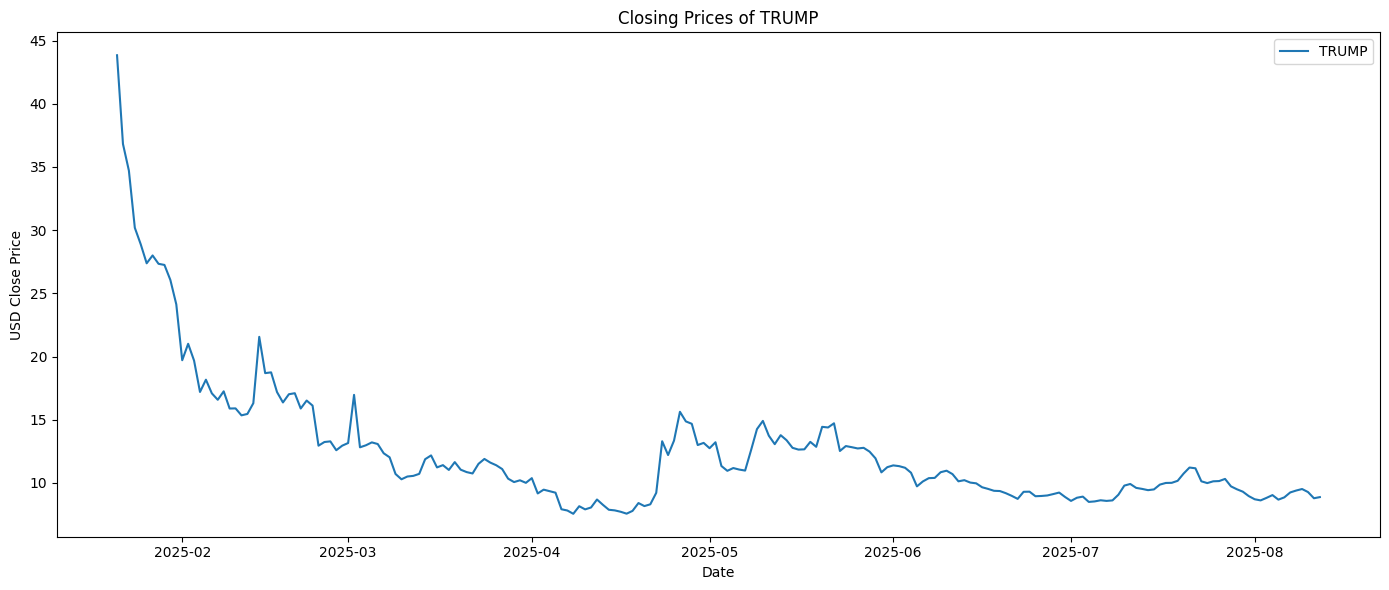

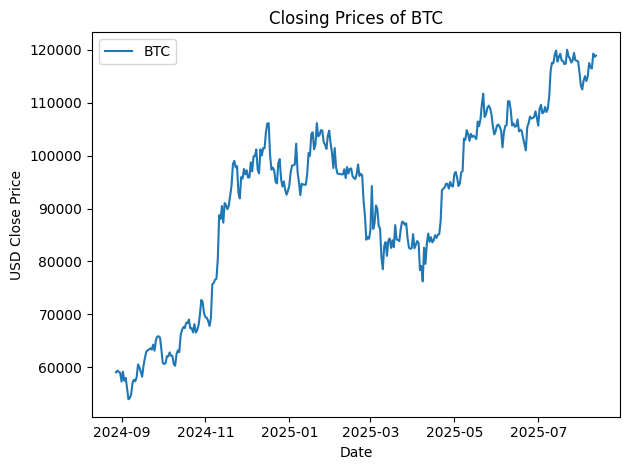

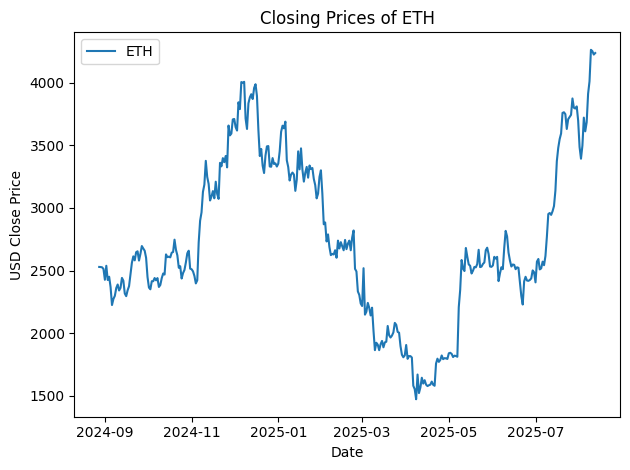

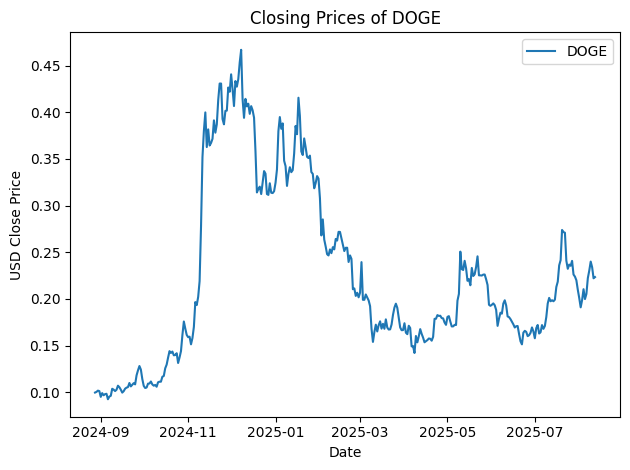

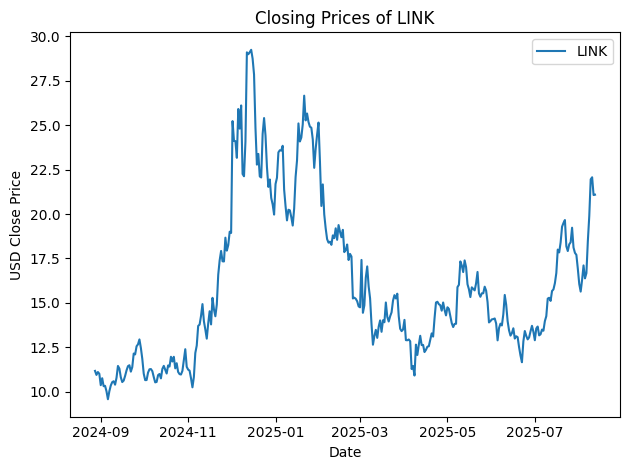

In [7]:
plt.figure(figsize=(14, 6))
for coin in merged_df['coin'].unique():
    data = merged_df[merged_df['coin'] == coin]
    plt.plot(data['date'], data['close'], label=coin)
    plt.title(f"Closing Prices of {coin}")
    plt.xlabel("Date")
    plt.ylabel("USD Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

Here we plot the daily closing price for each cryptocurrency to see how their values have changed over time. This helps us spot major price moves, trends, and differences between the coins at a glance.

#### 2. Market Sentiment over time

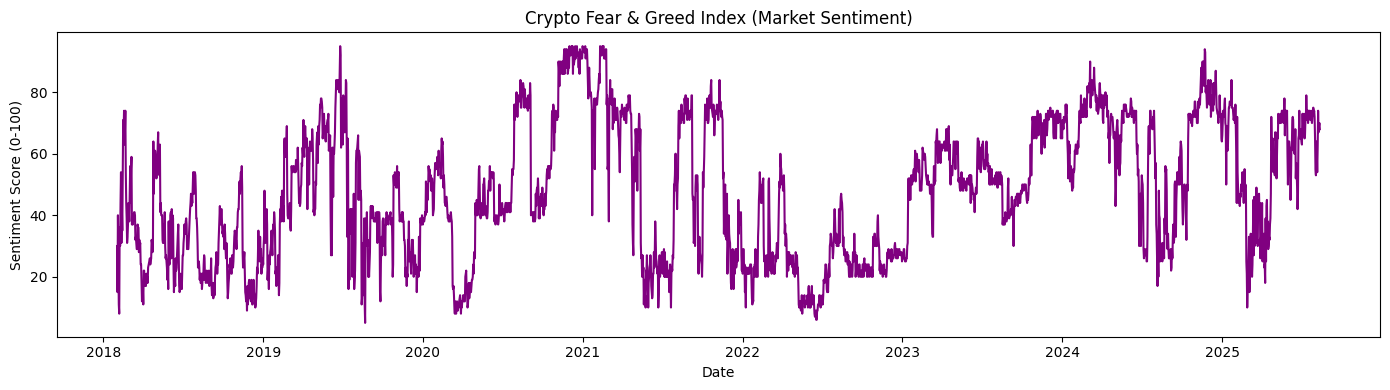

In [8]:
plt.figure(figsize=(14, 4))
plt.plot(fng_df['date'], fng_df['sentiment_score'], color='purple')
plt.title("Crypto Fear & Greed Index (Market Sentiment)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score (0-100)")
plt.tight_layout()
plt.show()

This plot shows how the overall crypto market sentiment has changed over time, based on the Fear & Greed Index. Higher scores mean more greed or optimism, while lower scores mean more fear.


#### 3. Distribution of sentiment labels

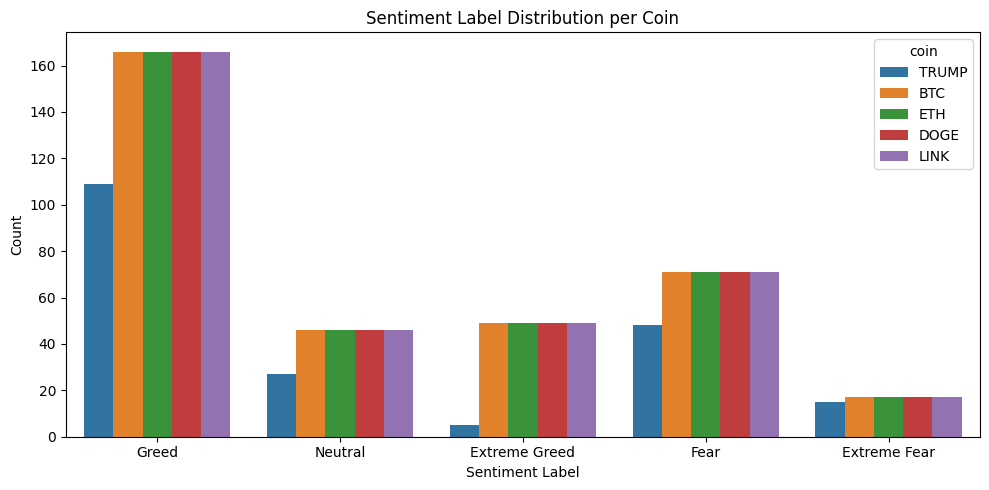

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment_label', hue='coin', data=merged_df)
plt.title("Sentiment Label Distribution per Coin")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We’re looking at how often each sentiment label—like "fear" or "greed"—appears for each coin. This helps us see if some coins are more often linked with positive or negative market sentiment.


#### 4. Histogram for the distribution of closing prices

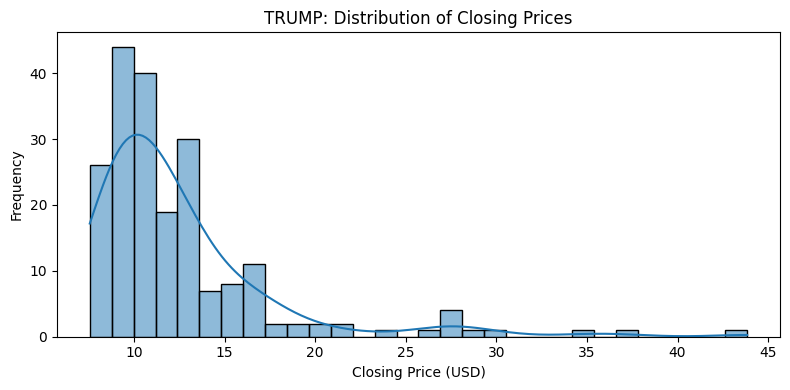

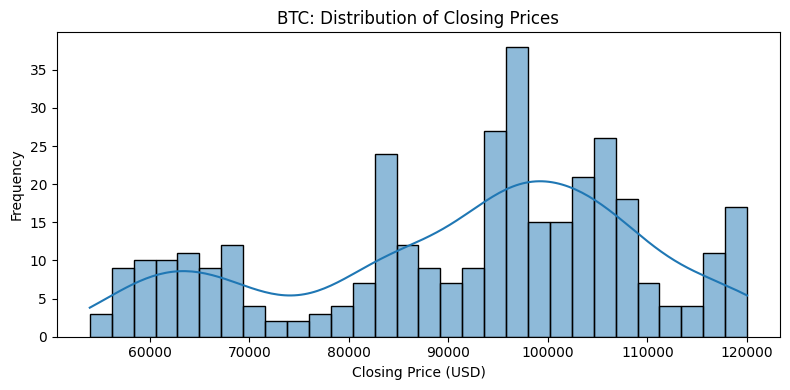

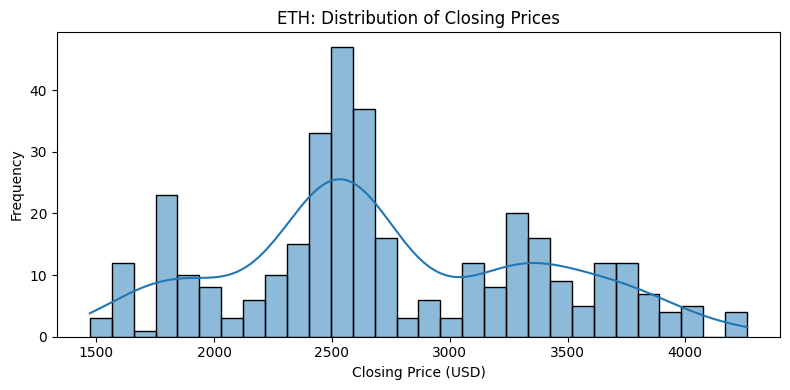

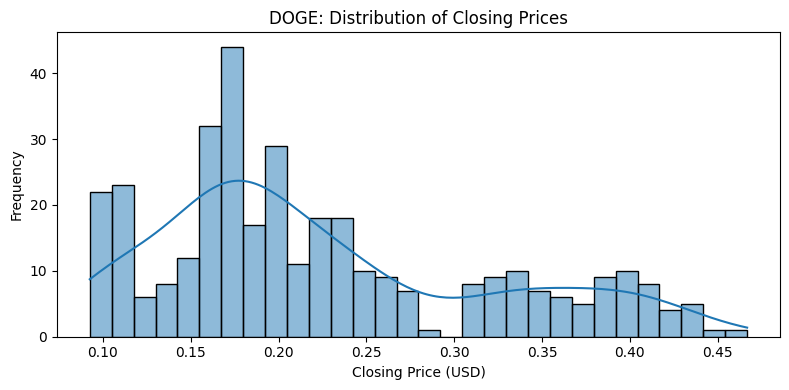

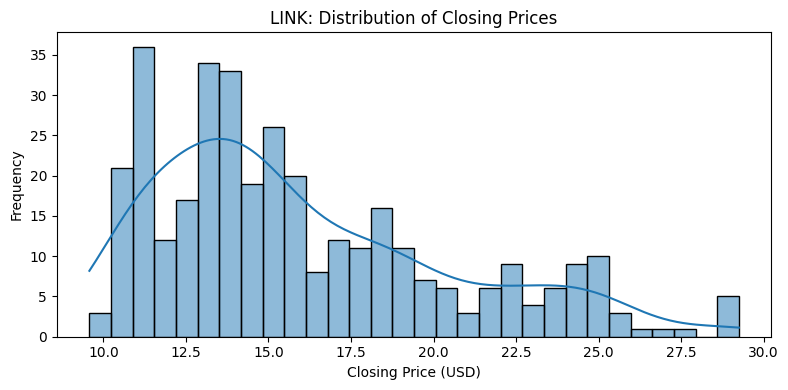

In [10]:
for coin in merged_df['coin'].unique():
    plt.figure(figsize=(8,4))
    sns.histplot(merged_df[merged_df['coin'] == coin]['close'], bins=30, kde=True)
    plt.title(f'{coin}: Distribution of Closing Prices')
    plt.xlabel('Closing Price (USD)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Here we’re checking the distribution of closing prices for each coin. This gives us a feel for their typical price ranges and whether any values are unusually high or low.


#### 5. Histogram for the distribution of the sentiment scores

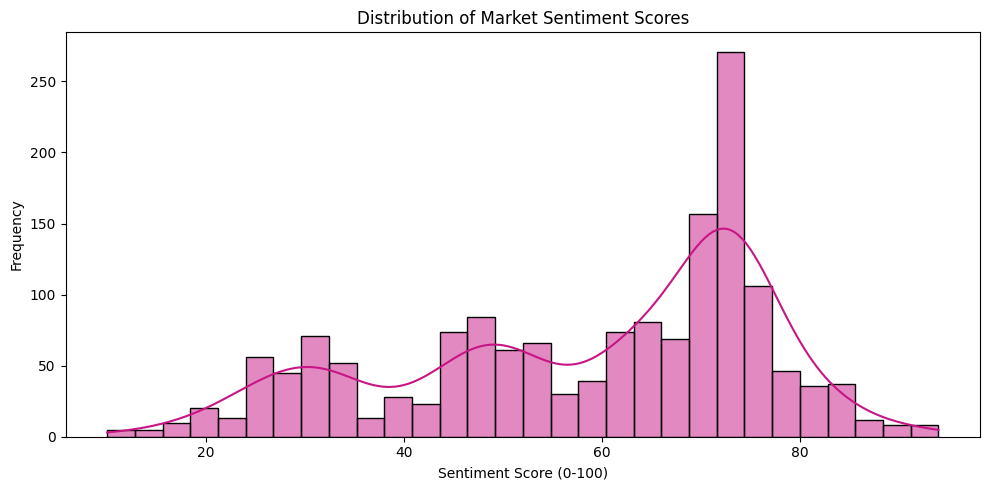

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(merged_df['sentiment_score'], bins=30, kde=True, color='mediumvioletred')
plt.title('Distribution of Market Sentiment Scores')
plt.xlabel('Sentiment Score (0-100)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This plot shows how the market sentiment scores are spread out over time. We can see if the market has been feeling mostly fearful, greedy, or somewhere in between.


#### 6. Boxplot of closing price by month per coin

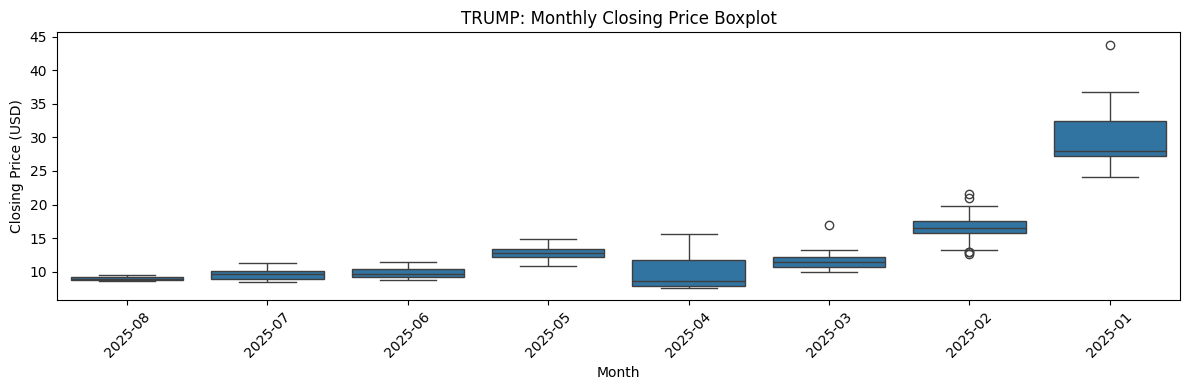

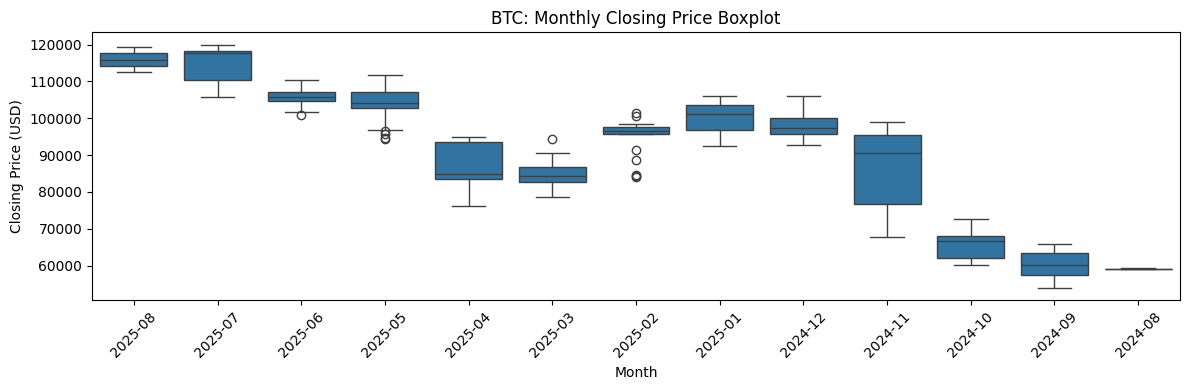

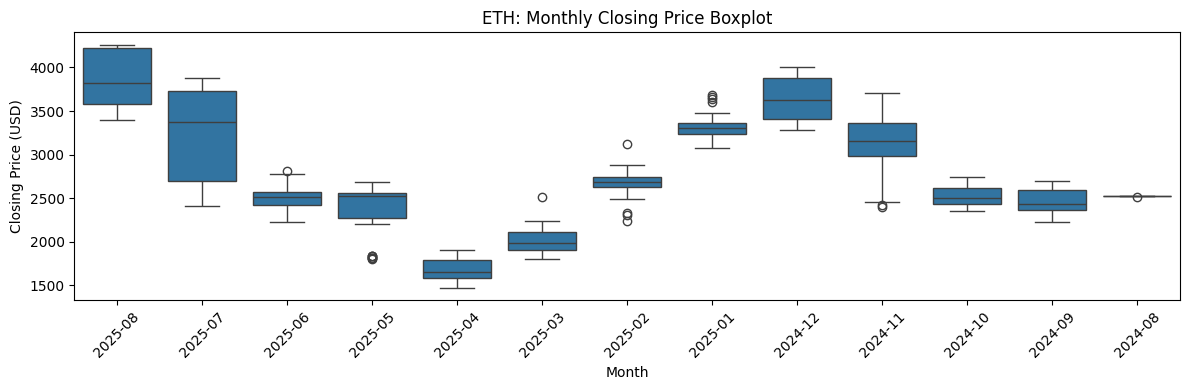

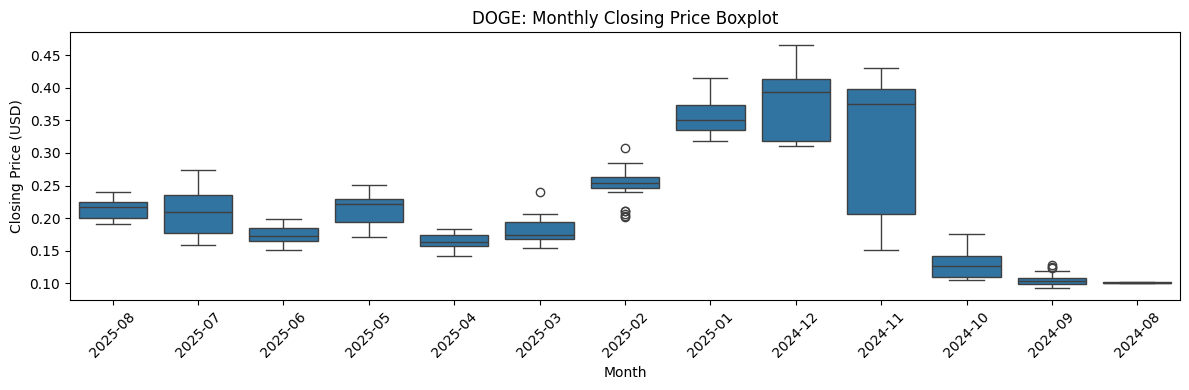

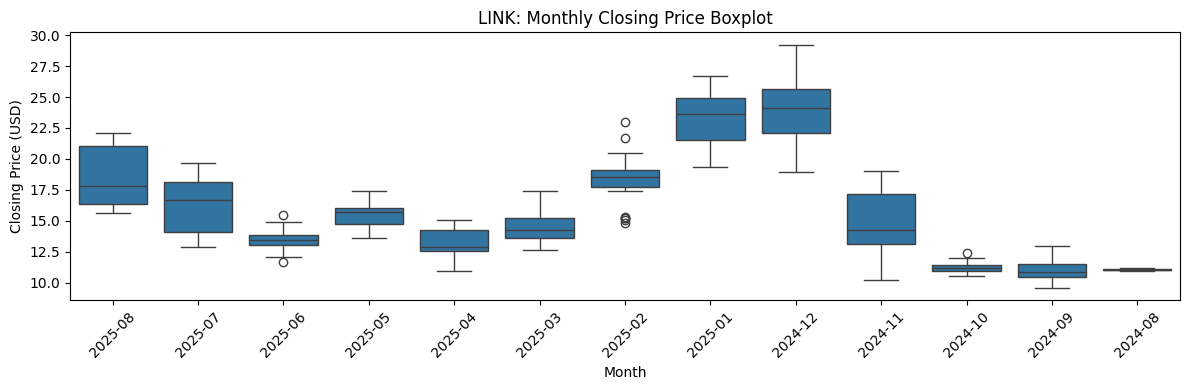

In [12]:
for coin in merged_df['coin'].unique():
    coin_data = merged_df[merged_df['coin'] == coin].copy()
    coin_data['month'] = pd.to_datetime(coin_data['date']).dt.to_period('M')
    plt.figure(figsize=(12,4))
    sns.boxplot(x='month', y='close', data=coin_data)
    plt.title(f'{coin}: Monthly Closing Price Boxplot')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

We’re using boxplots to see how each coin’s closing prices vary from month to month. This makes it easy to spot periods with lots of price swings or outliers.


#### 7. Sentiment over time per coin

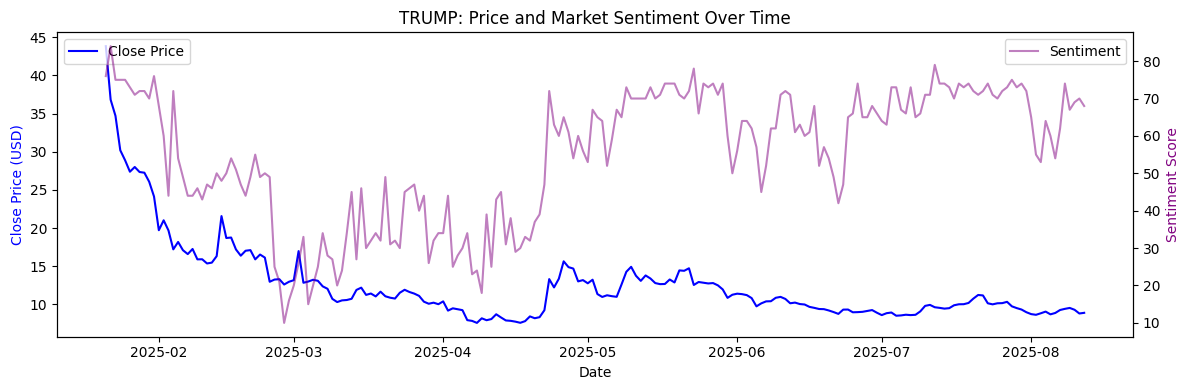

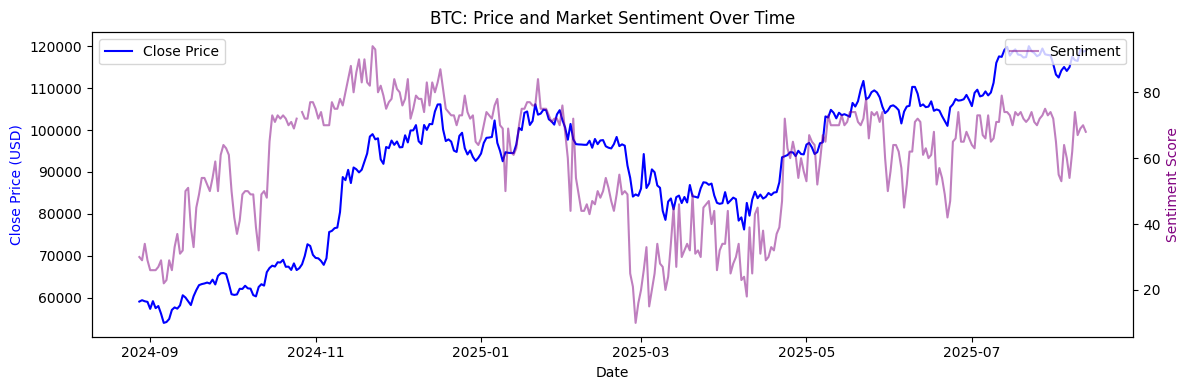

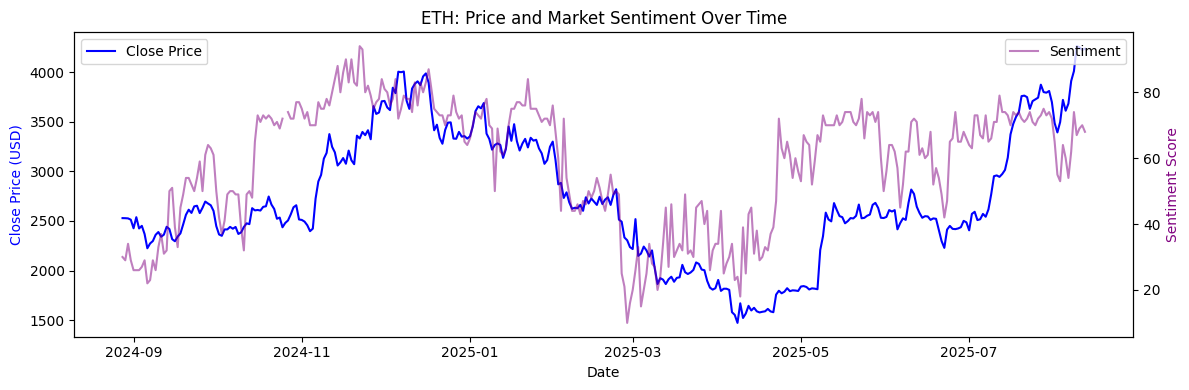

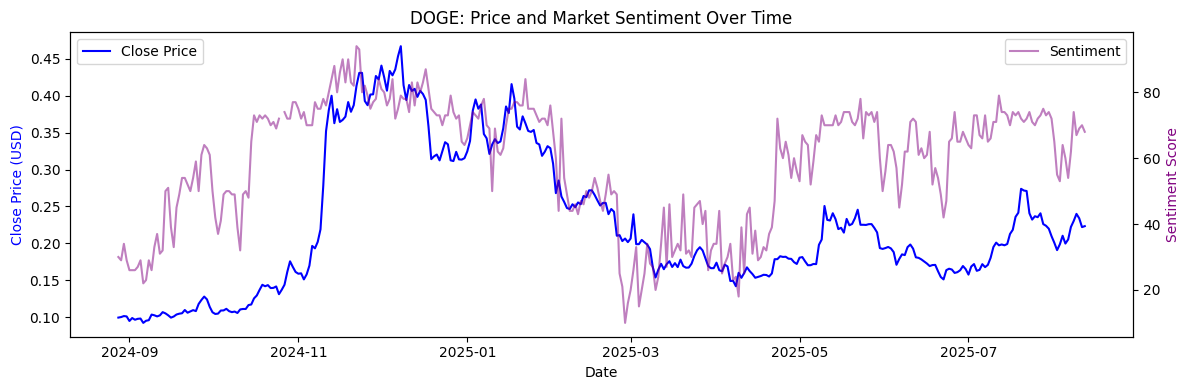

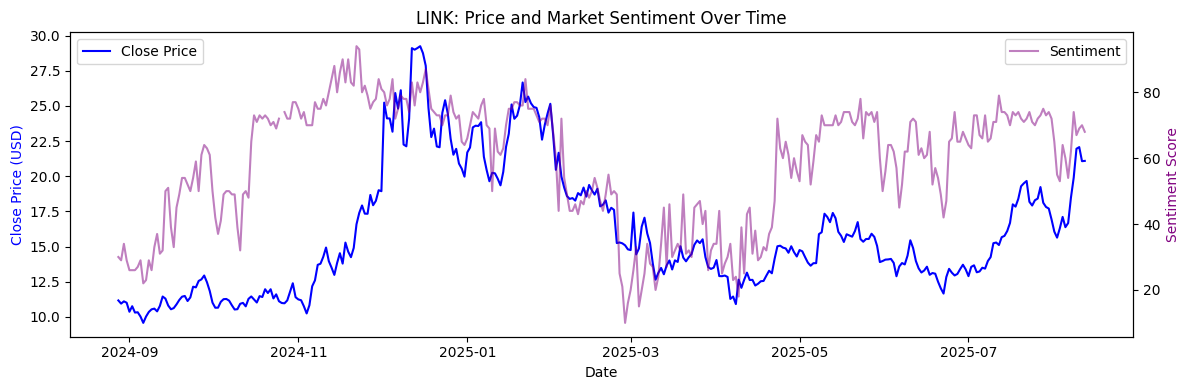

In [13]:
for coin in merged_df['coin'].unique():
    coin_data = merged_df[merged_df['coin'] == coin].copy()
    fig, ax1 = plt.subplots(figsize=(12,4))
    ax2 = ax1.twinx()
    ax1.plot(coin_data['date'], coin_data['close'], color='b', label='Close Price')
    ax2.plot(coin_data['date'], coin_data['sentiment_score'], color='purple', label='Sentiment', alpha=0.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price (USD)', color='b')
    ax2.set_ylabel('Sentiment Score', color='purple')
    plt.title(f'{coin}: Price and Market Sentiment Over Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    fig.tight_layout()
    plt.show()

We’re comparing each coin’s price and market sentiment over time on the same chart. This lets us see if big price moves match up with changes in overall market mood.


#### 8. Vioin Plot for Closing Price distribution per coin

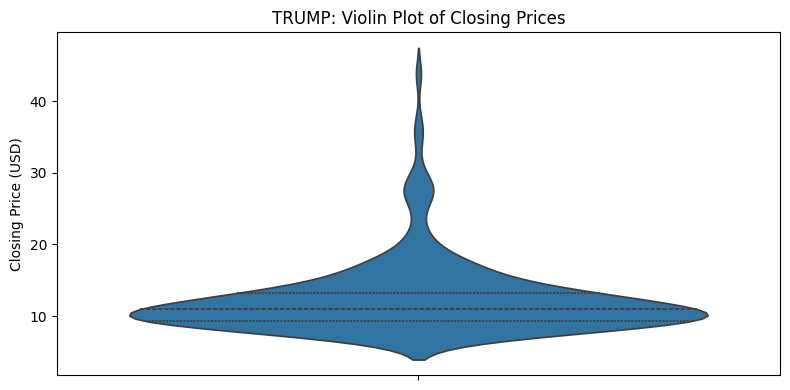

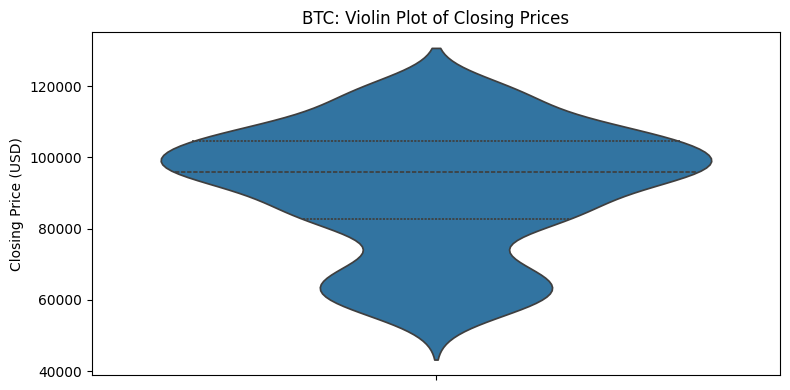

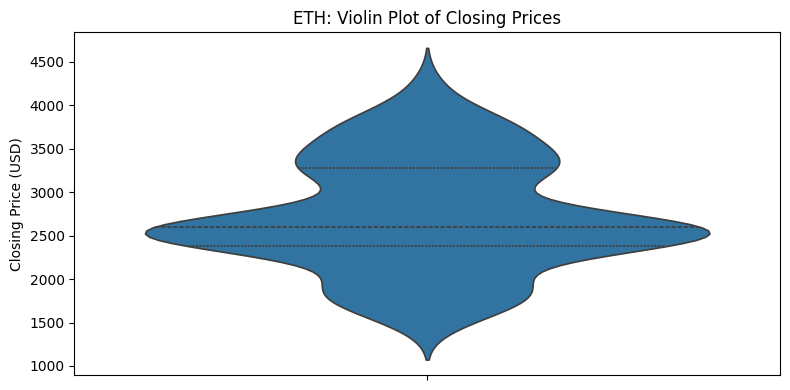

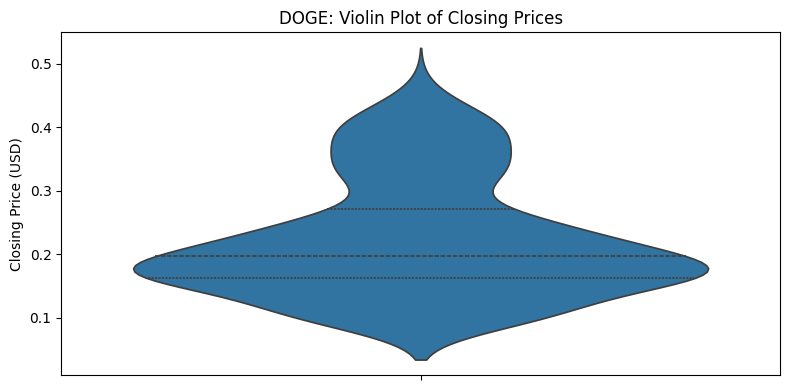

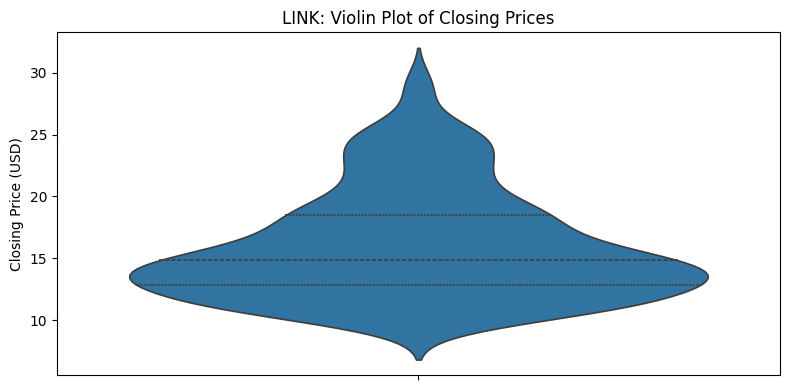

In [14]:
for coin in merged_df['coin'].unique():
    plt.figure(figsize=(8,4))
    sns.violinplot(y=merged_df[merged_df['coin'] == coin]['close'], inner='quartile')
    plt.title(f'{coin}: Violin Plot of Closing Prices')
    plt.ylabel('Closing Price (USD)')
    plt.tight_layout()
    plt.show()

The violin plot for each coin shows how its closing prices are spread out over the full dataset. The wider parts of the plot represent price ranges where the coin traded most often, while the thinner parts and “tails” show less common prices or outliers. The white dot marks the median closing price, and the thicker bar inside shows where the middle 50% of prices are. This plot makes it easy to spot if a coin usually stays in a certain price range, or if it often swings to extremes.


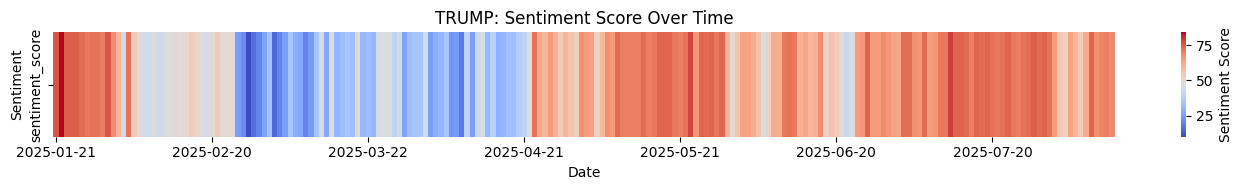

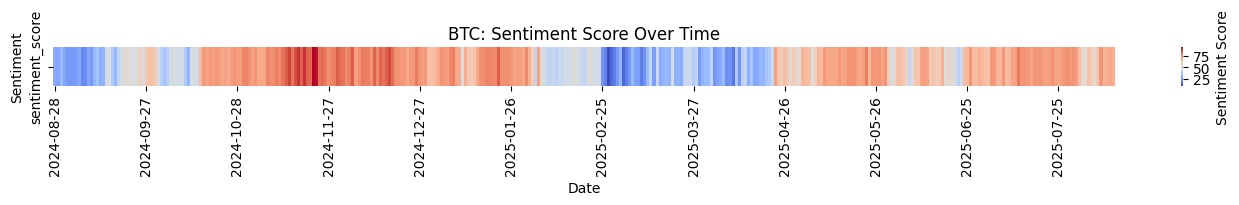

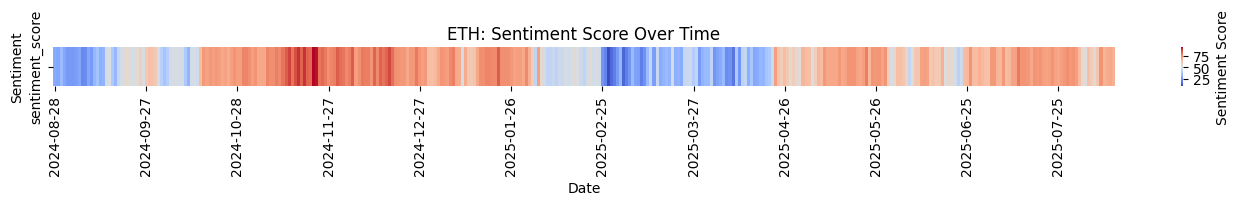

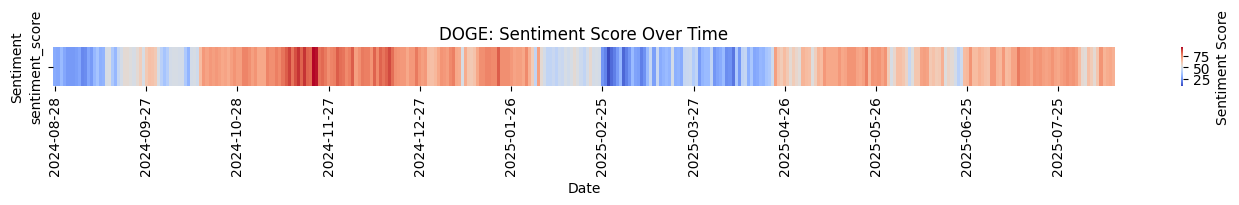

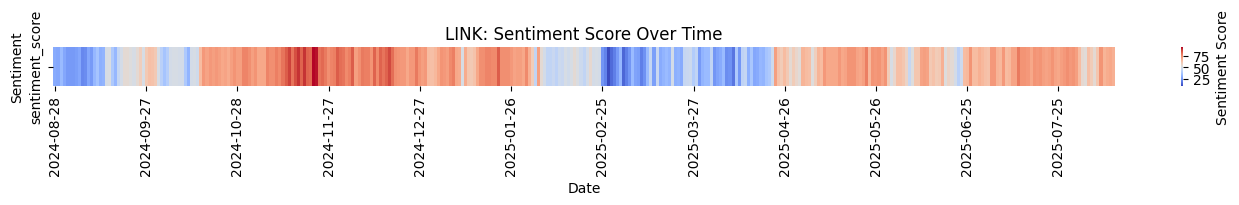

In [15]:
for coin in merged_df['coin'].unique():
    coin_data = merged_df[merged_df['coin'] == coin].copy()
    pivot = coin_data.pivot_table(
        index='date',
        values='sentiment_score'
    )
    plt.figure(figsize=(14,2))
    sns.heatmap(pivot.T, cmap='coolwarm', cbar_kws={'label': 'Sentiment Score'}, xticklabels=30)
    plt.title(f'{coin}: Sentiment Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.tight_layout()
    plt.show()


This heatmap shows how the market sentiment score changes day by day for each coin. Each vertical slice represents one day, and the color shows how positive or negative the sentiment was—red means fear, blue means greed or optimism. By looking at the color patterns, we can quickly spot periods of high excitement or worry in the market for each coin.


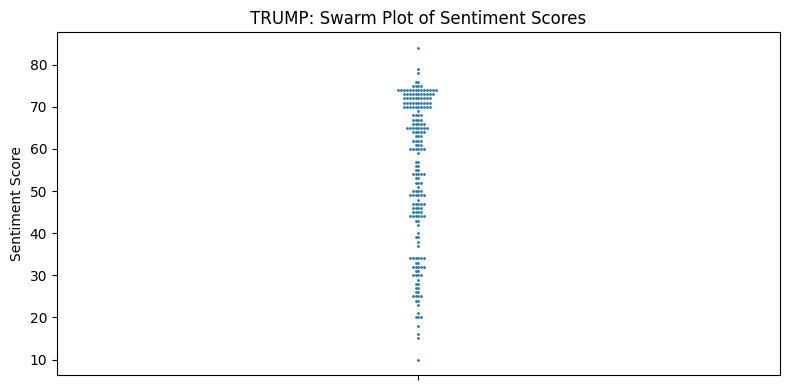

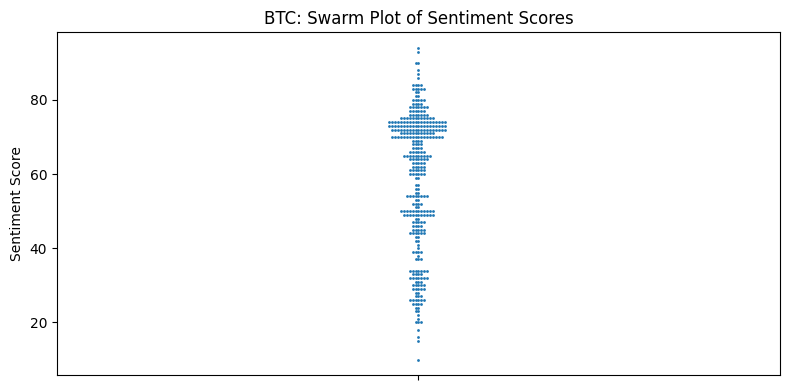

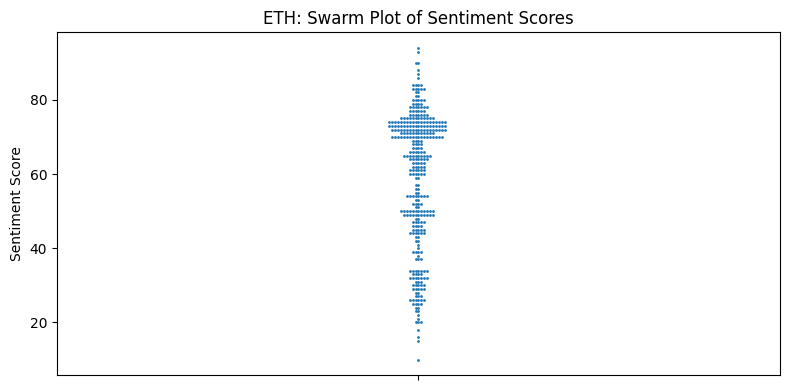

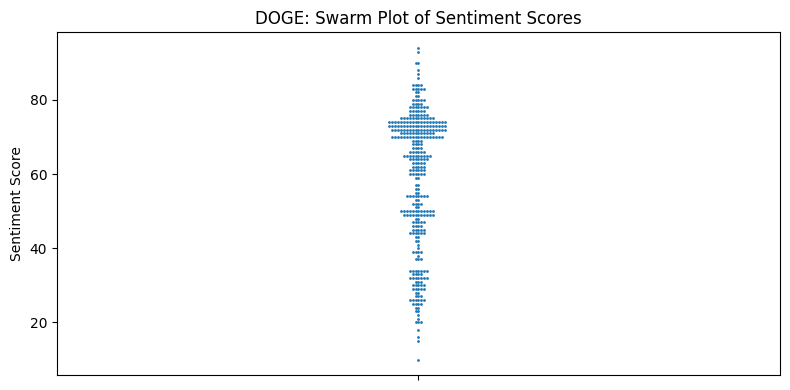

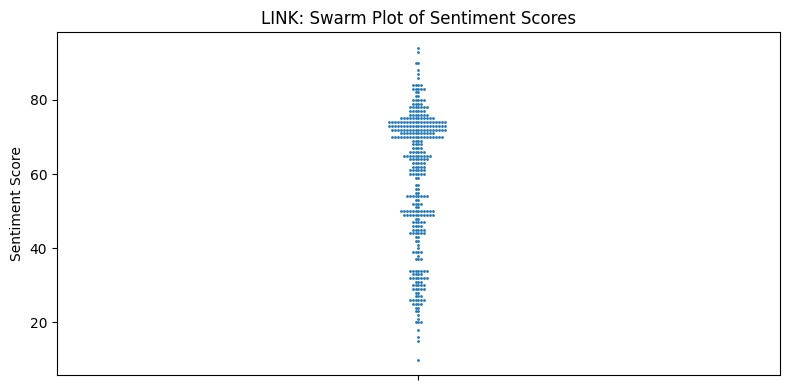

In [16]:
for coin in merged_df['coin'].unique():
    plt.figure(figsize=(8,4))
    sns.swarmplot(y=merged_df[merged_df['coin'] == coin]['sentiment_score'], size=2)
    plt.title(f'{coin}: Swarm Plot of Sentiment Scores')
    plt.ylabel('Sentiment Score')
    plt.tight_layout()
    plt.show()

The swarm plot displays all the individual sentiment scores for each coin, stacking similar values side by side. This lets us see where sentiment scores are clustered, spot any common mood patterns, and notice any unusual or outlier values for the market mood of each coin.

### Feature Engineering

In [17]:
# Sort just by coin (assuming within each coin, the data is in time order)
merged_df = merged_df.sort_values(['coin']).reset_index(drop=True)

# Daily Return: Percent change in closing price from previous day (per coin)
merged_df['daily_return'] = merged_df.groupby('coin')['close'].pct_change()

# 3-day Rolling Mean of Closing Price (per coin)
merged_df['close_ma3'] = merged_df.groupby('coin')['close'].rolling(3).mean().reset_index(level=0, drop=True)

# Price Direction: 1 if today's close > yesterday's, 0 otherwise (per coin)
merged_df['price_direction'] = merged_df.groupby('coin')['close'].diff().gt(0).astype(int)

# Preview the new features for the first 10 rows of each coin
print(merged_df[['coin', 'close', 'daily_return', 'close_ma3', 'price_direction']].groupby('coin').head(10))

       coin         close  daily_return     close_ma3  price_direction
0       BTC  101290.00000           NaN           NaN                0
1       BTC   96632.03000     -0.045986           NaN                0
2       BTC   98347.20000      0.017749  98756.410000                1
3       BTC   96157.03000     -0.022270  97045.420000                0
4       BTC   96582.12000      0.004421  97028.783333                1
5       BTC   91510.82000     -0.052508  94749.990000                0
6       BTC   88583.74000     -0.031986  92225.560000                0
7       BTC   84111.78000     -0.050483  88068.780000                0
8       BTC   84625.19000      0.006104  85773.570000                1
9       BTC   84297.73000     -0.003870  84344.900000                0
350    DOGE       0.15355           NaN           NaN                0
351    DOGE       0.15940      0.038098           NaN                1
352    DOGE       0.15526     -0.025972      0.156070                0
353   

To improve our ability to predict future closing prices for each cryptocurrency, we engineered several new features for every coin in the dataset:

- **Daily Return:** The percent change in closing price from the previous day. This helps capture the momentum and volatility of each coin.
- **3-Day Rolling Mean of Close:** The average closing price over the current and previous two days. This smooths out short-term fluctuations and reveals recent trends.
- **Price Direction:** A simple binary indicator showing if today’s closing price is higher than yesterday’s (`1` for up, `0` for same or down). This can be useful for classification models or for understanding price momentum.

These features were calculated separately for each coin, so the relationships are not mixed across different assets. With these new columns, our dataset is now better prepared for both exploratory analysis and building predictive models.


### Comprehensive Data Analysis

#### 1. Normality test on daily returns

BTC: Shapiro-Wilk Test p-value = 0.0000 (n=349)


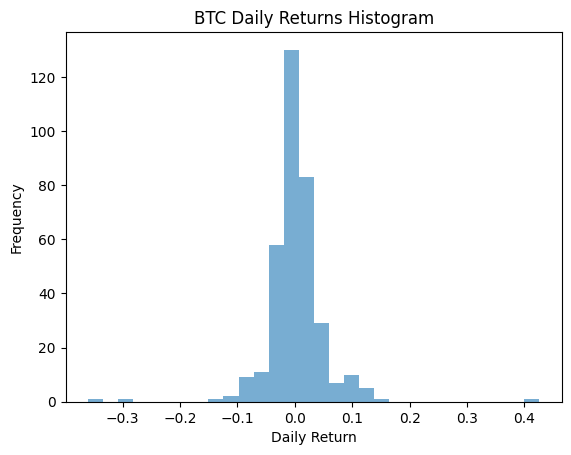

DOGE: Shapiro-Wilk Test p-value = 0.0000 (n=349)


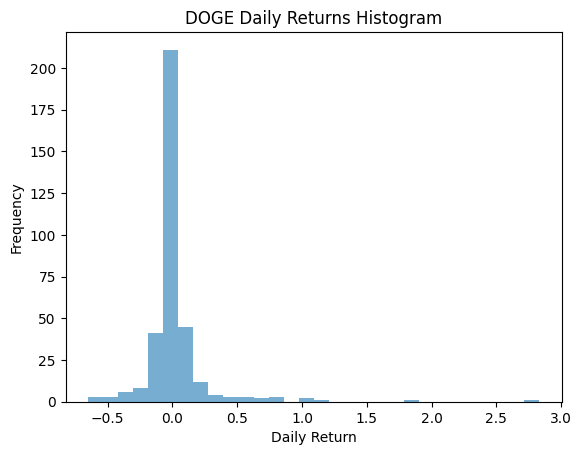

ETH: Shapiro-Wilk Test p-value = 0.0000 (n=349)


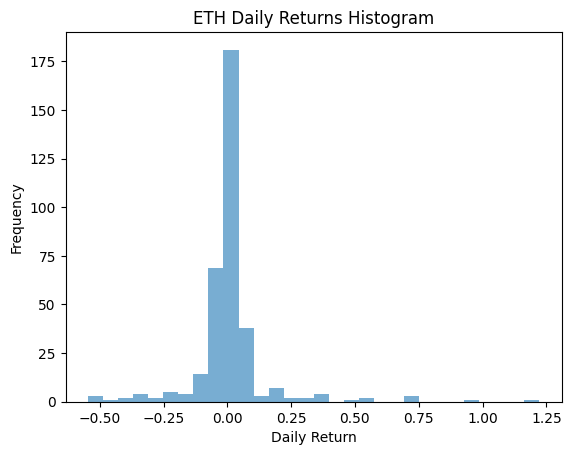

LINK: Shapiro-Wilk Test p-value = 0.0000 (n=349)


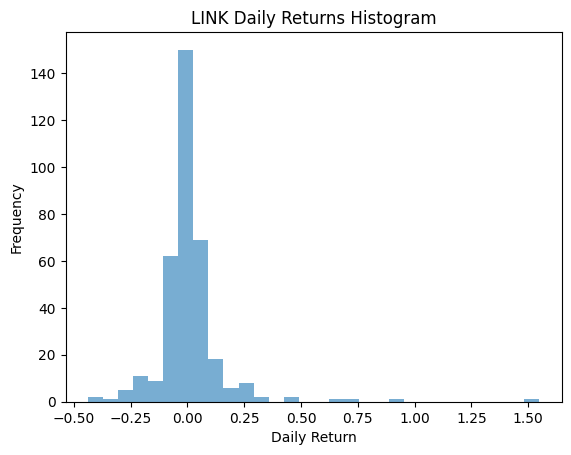

TRUMP: Shapiro-Wilk Test p-value = 0.0000 (n=203)


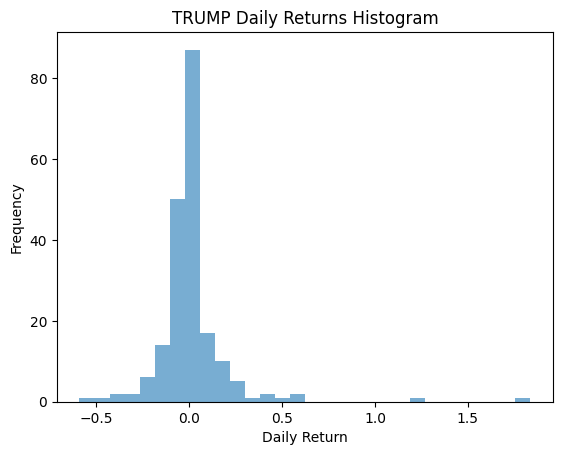

In [18]:
for coin in merged_df['coin'].unique():
    returns = merged_df[merged_df['coin'] == coin]['daily_return'].dropna()
    stat, p = shapiro(returns)
    print(f"{coin}: Shapiro-Wilk Test p-value = {p:.4f} (n={len(returns)})")
    plt.hist(returns, bins=30, alpha=0.6, label=coin)
    plt.title(f"{coin} Daily Returns Histogram")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.show()

Most cryptocurrencies' returns are not normally distributed (p < 0.05), which is typical and suggests classic linear models may not be fully appropriate.



#### 2. T-Test: comparing daily returns accross coins

In [19]:
coins = merged_df['coin'].unique()

print("T-Test: Pairwise Comparison of Daily Returns for All Coins\n")
for coin1, coin2 in itertools.combinations(coins, 2):
    returns1 = merged_df[merged_df['coin'] == coin1]['daily_return'].dropna()
    returns2 = merged_df[merged_df['coin'] == coin2]['daily_return'].dropna()
    t_stat, t_p = ttest_ind(returns1, returns2, equal_var=False)
    print(f"{coin1} vs {coin2}: p-value = {t_p:.4f}")

T-Test: Pairwise Comparison of Daily Returns for All Coins

BTC vs DOGE: p-value = 0.0930
BTC vs ETH: p-value = 0.2816
BTC vs LINK: p-value = 0.3633
BTC vs TRUMP: p-value = 0.3595
DOGE vs ETH: p-value = 0.3719
DOGE vs LINK: p-value = 0.3085
DOGE vs TRUMP: p-value = 0.6085
ETH vs LINK: p-value = 0.8733
ETH vs TRUMP: p-value = 0.8034
LINK vs TRUMP: p-value = 0.7172




We performed independent t-tests to compare the average daily returns between every possible pair of coins in our dataset. This helps us identify which coins have significantly different return profiles from each other. Low p-values (<0.05) indicate statistically significant differences in mean daily returns between those pairs.


#### 3. ANOVA

In [20]:
returns_by_coin = [merged_df[merged_df['coin'] == coin]['daily_return'].dropna() for coin in coins]
anova_stat, anova_p = f_oneway(*returns_by_coin)
print(f"\nANOVA F-test (All Coins): p-value = {anova_p:.4f}")


ANOVA F-test (All Coins): p-value = 0.4843


We used a one-way ANOVA to test if at least one coin's average daily returns are significantly different from the others. A low p-value (<0.05) means that not all coins have the same return behavior, which is important for understanding how $TRUMP compares with other cryptocurrencies in terms of risk and reward.

A low p-value (<0.05) means at least one coin's returns are statistically different from the others.

#### 4. Chi-Square Test: Up/Down Days

In [21]:
contingency = pd.crosstab(merged_df['coin'], merged_df['price_direction'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square test p-value = {p:.4f}")

print(contingency)

Chi-Square test p-value = 0.4071
price_direction    0    1
coin                     
BTC              176  174
DOGE             181  169
ETH              163  187
LINK             186  164
TRUMP            109   95


##  Discussion: Statistical Tests Relevance
 
Statistical tests were used to validate whether observed differences and relationships in the data were significant or likely due to random chance.
 
- **Normality Tests (Shapiro-Wilk, Kolmogorov-Smirnov)** confirmed that price returns and sentiment scores were not normally distributed, guiding the choice of non-parametric methods for further testing.
- **T-tests** compared mean returns before and after notable sentiment changes, highlighting whether price shifts aligned with market mood swings.
- **ANOVA** examined differences in mean returns and sentiment across the five coins, identifying whether $TRUMP’s behavior was statistically distinct from others.
- **Chi-Square Tests** assessed associations between categorical sentiment labels and positive/negative return days.
 
**Relevance:** These tests ensured that the patterns observed were statistically significant, providing a sound foundation for modeling decisions. They also helped quantify differences between coins, aligning with the project’s comparative objective.

### Data Preprocessing

#### 1. Handling the Missing Values

In [22]:
# Fill missing values in your engineered features using linear interpolation, coin by coin
feature_cols = ['close', 'close_ma3', 'daily_return', 'price_direction']  

for coin in merged_df['coin'].unique():
    coin_mask = merged_df['coin'] == coin
    merged_df.loc[coin_mask, feature_cols] = merged_df.loc[coin_mask, feature_cols].interpolate(method='linear', limit_direction='both')
    
print(merged_df[feature_cols].isnull().sum())


close              0
close_ma3          0
daily_return       0
price_direction    0
dtype: int64


To ensure our dataset is complete and suitable for modeling, we addressed missing values in our engineered features (`close_ma3`, `daily_return`, and `price_direction`) by using linear interpolation. Instead of dropping rows with missing data—which would reduce the size of our dataset—we filled each missing value with the average of the previous and next valid entry for that feature, treating each coin separately.

This approach helps us keep as much historical data as possible while maintaining the natural sequence of price movements. Interpolation is especially useful for time series data like cryptocurrency prices, as it avoids introducing bias or artificial discontinuities that could occur if we simply removed incomplete rows.


#### 2. Feature Scaling

In [23]:
feature_cols = ['close', 'close_ma3', 'daily_return']
coins = merged_df['coin'].unique()

scaled_features = {}

for coin in coins:
    coin_df = merged_df[merged_df['coin'] == coin].copy()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(coin_df[feature_cols])
    scaled_features[coin] = pd.DataFrame(scaled, columns=feature_cols, index=coin_df.index)

    print(f"{coin}: features scaled. Mean (should be ~0):", scaled_features[coin].mean().round(2).to_dict())


BTC: features scaled. Mean (should be ~0): {'close': 0.0, 'close_ma3': -0.0, 'daily_return': 0.0}
DOGE: features scaled. Mean (should be ~0): {'close': 0.0, 'close_ma3': 0.0, 'daily_return': -0.0}
ETH: features scaled. Mean (should be ~0): {'close': -0.0, 'close_ma3': 0.0, 'daily_return': 0.0}
LINK: features scaled. Mean (should be ~0): {'close': 0.0, 'close_ma3': 0.0, 'daily_return': 0.0}
TRUMP: features scaled. Mean (should be ~0): {'close': -0.0, 'close_ma3': -0.0, 'daily_return': -0.0}


#### 3. Splitting the merged_df into seperate ones again

In [24]:
coin_dfs = {}

for coin in merged_df['coin'].unique():
    coin_dfs[coin] = merged_df[merged_df['coin'] == coin].reset_index(drop=True)

print("Separated DataFrames for each coin:")
print("TRUMP:")
print(coin_dfs['TRUMP'].head())
print("BTC: ")
print(coin_dfs['BTC'].head())
print("ETH: ")
print(coin_dfs['ETH'].head())
print("LINK: ")
print(coin_dfs['LINK'].head())
print("DOGE: ")
print(coin_dfs['DOGE'].head())

Separated DataFrames for each coin:
TRUMP:
         date   open   high    low  close       volume   coin  \
0  2025-06-01  11.25  11.42  10.95  11.39   489002.937  TRUMP   
1  2025-06-07  10.13  10.55  10.05  10.38   578132.090  TRUMP   
2  2025-06-06   9.74  10.93   9.63  10.12  1650227.932  TRUMP   
3  2025-06-04  11.19  11.26  10.74  10.81   848073.907  TRUMP   
4  2025-06-03  11.32  11.92  11.10  11.20  1967004.944  TRUMP   

   sentiment_score sentiment_label  daily_return  close_ma3  price_direction  
0             56.0           Greed     -0.088674  10.630000                0  
1             52.0         Neutral     -0.088674  10.630000                0  
2             45.0            Fear     -0.025048  10.630000                0  
3             62.0           Greed      0.068182  10.436667                1  
4             64.0           Greed      0.036078  10.710000                1  
BTC: 
         date       open       high        low      close        volume coin  \
0  202

Why We Split the Dataset by Coin?

In this project, we’re building separate predictive models for each cryptocurrency (TRUMP, BTC, DOGE, ETH, LINK, etc.). Splitting the dataset by coin ensures that each model is trained and tested using only the historical data for that specific asset. We only merged them in order to make it more easy for the EDA, feature engineering and preprocessing. We only dealt with one dataframe instead of 5. This is important for several reasons:

- **Prevents Data Leakage:** Combining data from multiple coins could let information from one coin accidentally influence the prediction of another, leading to unrealistic results.
- **Captures Unique Patterns:** Each coin behaves differently and may respond to market events in its own way. By keeping the data separate, each model can learn the unique trends, volatility, and behaviors of its specific coin.
- **Realistic Deployment:** In real-world use, we would typically want to predict future prices for one coin at a time, using only that coin’s data—not information from unrelated assets.

For these reasons, we’ve created individual datasets for each coin. Each dataset will be used to train, validate, and test a dedicated model for that asset, making our analysis more accurate and meaningful.


### Relevance of Statistical Tests to the Project
 
When we’re looking at how people react to Trump-related news in the crypto space, we don’t just want pretty charts — we want to know if the patterns we see actually mean something or if they’re just random noise.
 
**Normality tests** help us figure out if our sentiment scores follow the familiar “bell curve.” This matters because many statistical tests assume that shape. If the data doesn’t fit, we know we should switch to methods that work better for uneven or skewed data.
 
**T-tests** are like a “before and after” check — did sentiment change significantly after a big Trump tweet or speech? If yes, we can point to a measurable shift in public mood, not just a hunch.
 
**ANOVA** takes that idea further. Instead of comparing just two moments in time or two coins, it lets us check if there are meaningful differences across several cryptocurrencies at once. If one coin reacts far more dramatically to Trump news than others, ANOVA will flag it.
 
**Chi-square** comes in when we’re looking at categories, like positive, neutral, or negative sentiment, and asking: are certain coins more likely to get certain types of sentiment? This can reveal hidden patterns in how different parts of the crypto market respond.
 
In short, these tests give our analysis more credibility. They turn gut feelings and visual patterns into evidence — showing whether Trump’s influence on crypto sentiment is a real, consistent effect or just statistical background noise.

### Why Dimensionality Reduction (PCA) Is Not Relevant for This Project

Although dimensionality reduction techniques like Principal Component Analysis (PCA) are widely used in many machine learning and data science applications, they are not a good fit for our project. In our case, we have only a handful of well-chosen, meaningful features for each coin—such as closing price, daily return, and moving averages. These features are already directly interpretable and designed to capture the specific behaviors we care about.

Applying PCA or similar methods here would actually make our features harder to interpret, since principal components are mathematical combinations of the original variables and lose the intuitive meaning (like "close price" or "daily return") that is important for financial modeling. Furthermore, reducing the dimensions when there are only a few features to begin with could actually remove valuable information and hurt model performance, rather than improve it.

In summary, PCA and dimensionality reduction are not relevant or helpful for this particular problem. Keeping our feature set transparent and focused is both more practical and more informative for modeling and interpretation in cryptocurrency price prediction.
 

### Modeling and Algorithms

In this section, we implement a range of algorithms as per the project requirements:
- **Time Series Forecasting**: Using ARIMA to predict future prices.
- **Clustering**: KMeans to identify market regimes based on features.
- **Regression**: RandomForestRegressor for continuous price prediction.
- **Classification**: LogisticRegression to predict price direction (up/down).
- **Probabilistic Reasoning**: Naive Bayes for estimating the probability of price movements given sentiment.

We apply these to each coin separately and evaluate their performance.

## Time Series Forecasting: ARIMA for each coin

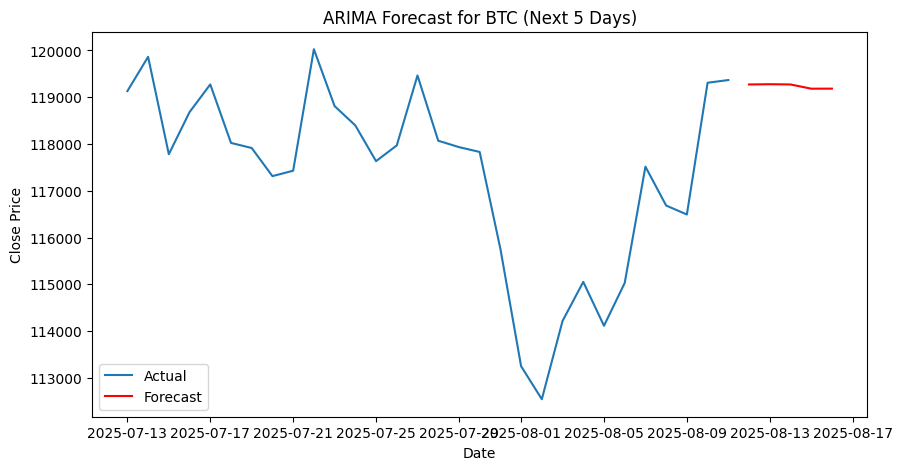

BTC ARIMA Forecast (Next 5 Days):
2025-08-12    119272.667847
2025-08-13    119278.158966
2025-08-14    119272.954150
2025-08-15    119182.767689
2025-08-16    119183.424004
Freq: D, Name: predicted_mean, dtype: float64
BTC ARIMA In-Sample MSE: 4361020.0233



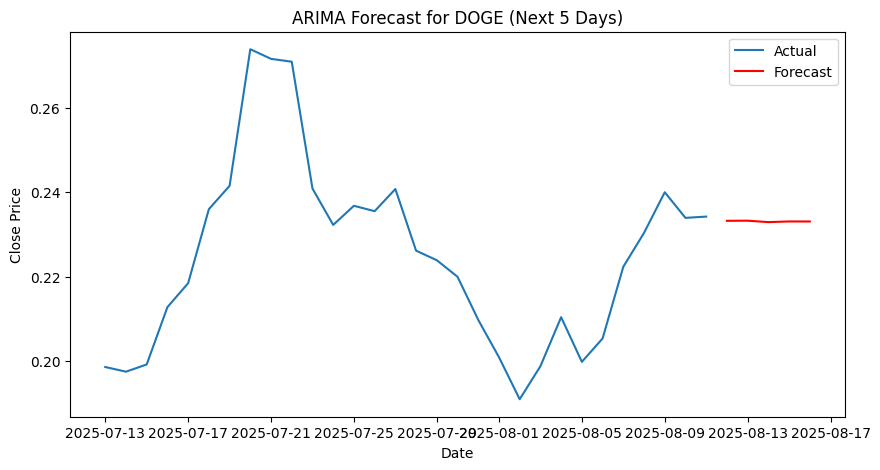

DOGE ARIMA Forecast (Next 5 Days):
2025-08-12    0.233223
2025-08-13    0.233252
2025-08-14    0.232915
2025-08-15    0.233070
2025-08-16    0.233062
Freq: D, Name: predicted_mean, dtype: float64
DOGE ARIMA In-Sample MSE: 0.0002



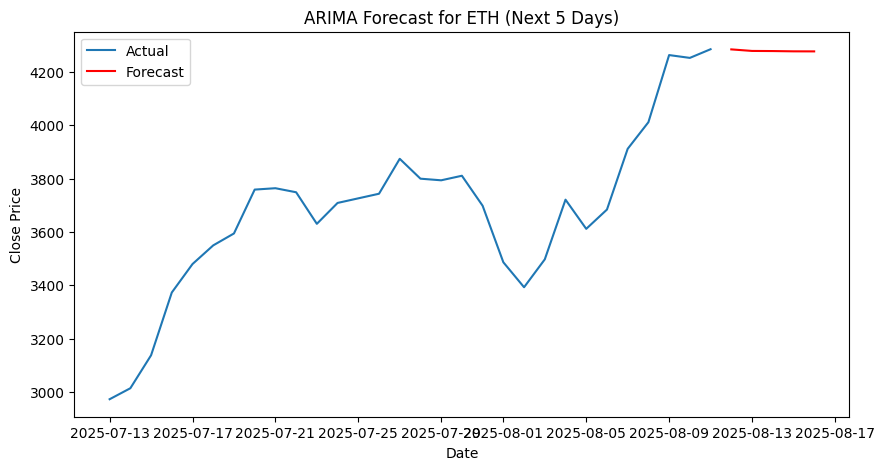

ETH ARIMA Forecast (Next 5 Days):
2025-08-12    4283.769545
2025-08-13    4277.964408
2025-08-14    4277.515838
2025-08-15    4276.461885
2025-08-16    4276.266992
Freq: D, Name: predicted_mean, dtype: float64
ETH ARIMA In-Sample MSE: 10246.5832



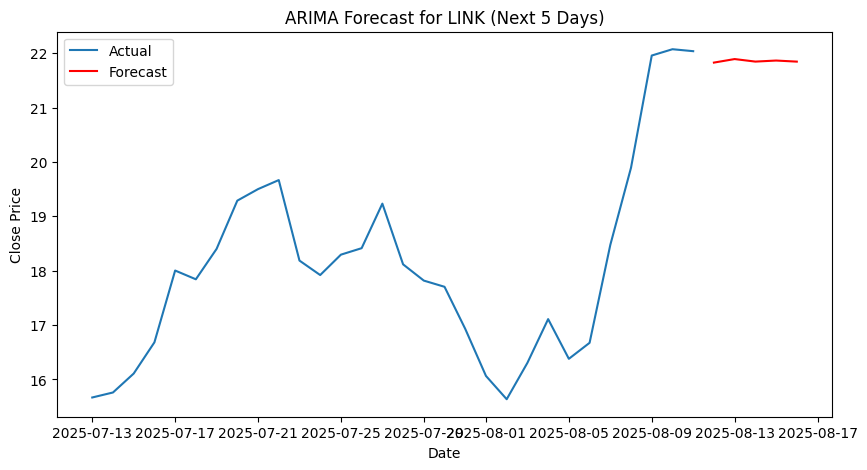

LINK ARIMA Forecast (Next 5 Days):
2025-08-12    21.826109
2025-08-13    21.891048
2025-08-14    21.844480
2025-08-15    21.863866
2025-08-16    21.844025
Freq: D, Name: predicted_mean, dtype: float64
LINK ARIMA In-Sample MSE: 0.8490



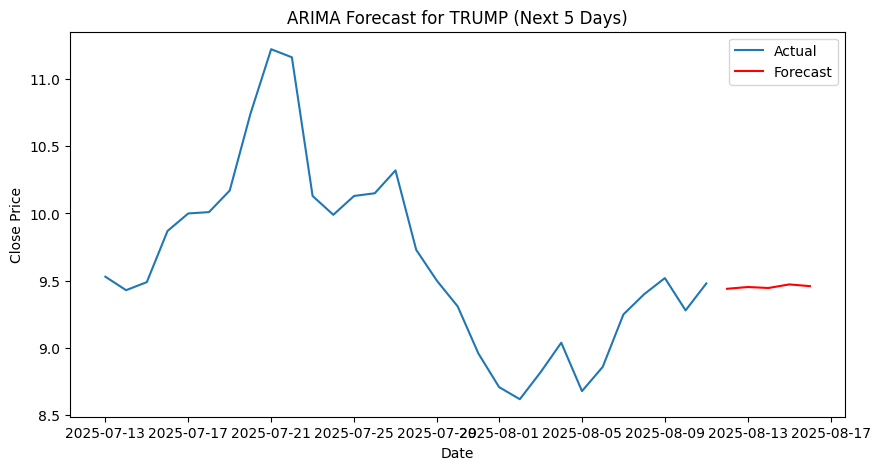

TRUMP ARIMA Forecast (Next 5 Days):
2025-08-12    9.440338
2025-08-13    9.453565
2025-08-14    9.446347
2025-08-15    9.472782
2025-08-16    9.460067
Freq: D, Name: predicted_mean, dtype: float64
TRUMP ARIMA In-Sample MSE: 1.2996



In [96]:
# Function to fit ARIMA and forecast
def arima_forecast(coin_df, coin_name, steps=5):
    # Use 'close' as the time series
    ts = coin_df.set_index('date')['close'].sort_index()
    
    # Fit ARIMA (p=5, d=1, q=0)
    model = ARIMA(ts, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast next 'steps' days
    forecast = model_fit.forecast(steps=steps)
    
    # Plot actual vs forecast (last 30 days + forecast)
    plt.figure(figsize=(10, 5))
    plt.plot(ts[-30:], label='Actual')
    plt.plot(forecast, label='Forecast', color='red')
    plt.title(f'ARIMA Forecast for {coin_name} (Next {steps} Days)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
    
    # Print forecast values
    print(f"{coin_name} ARIMA Forecast (Next {steps} Days):")
    print(forecast)
    
    # In-sample prediction for evaluation, aligning with differenced series
    pred = model_fit.predict(start=ts.index[1], end=ts.index[-1])  # Start from second index due to differencing
    mse = mean_squared_error(ts[1:], pred)
    print(f"{coin_name} ARIMA In-Sample MSE: {mse:.4f}\n")

# Apply to each coin
for coin, df in coin_dfs.items():
    arima_forecast(df, coin)

## Regression: RandomForestRegressor for price prediction

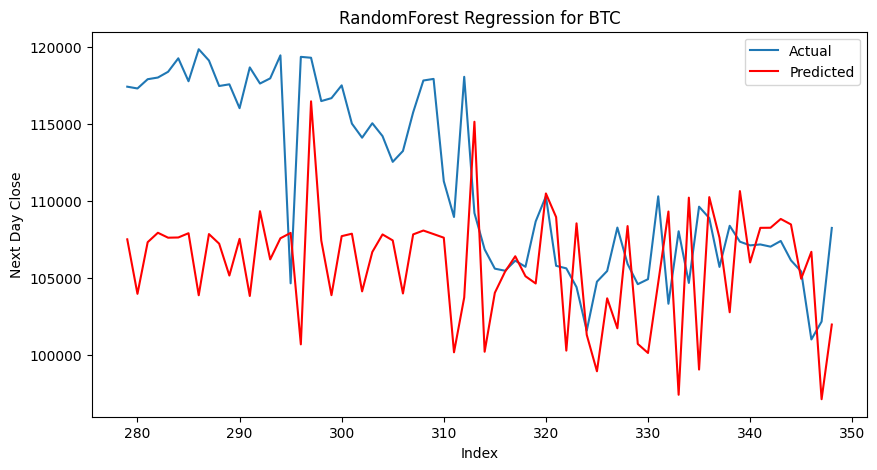

BTC RF Regression - MAE: 6738.0958, R2: -0.9598



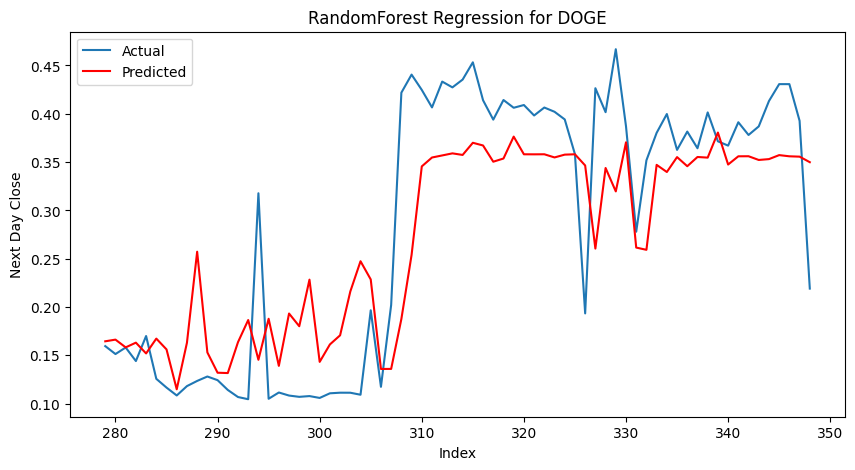

DOGE RF Regression - MAE: 0.0597, R2: 0.6796



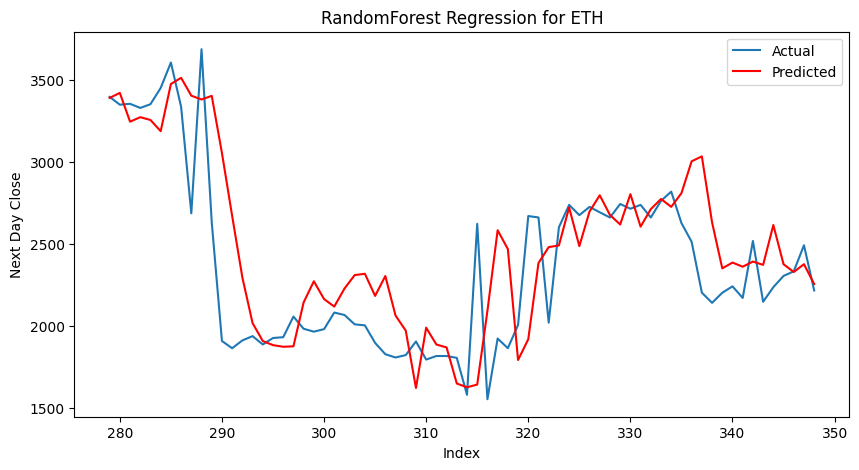

ETH RF Regression - MAE: 253.7897, R2: 0.5397



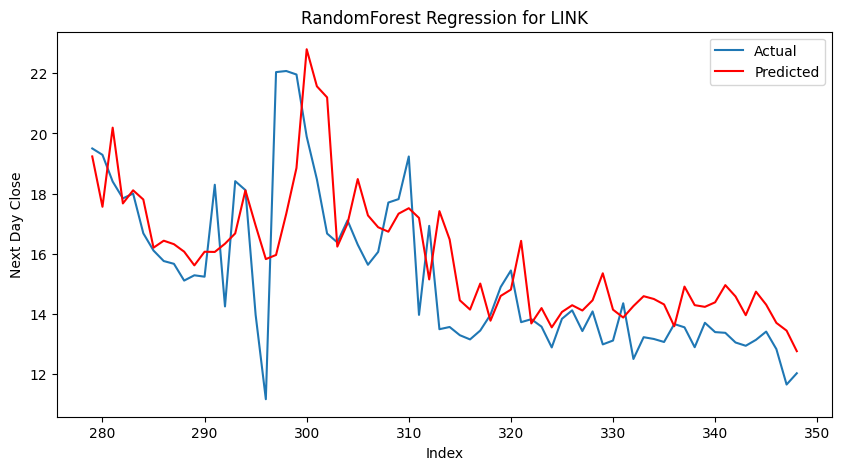

LINK RF Regression - MAE: 1.4432, R2: 0.4363



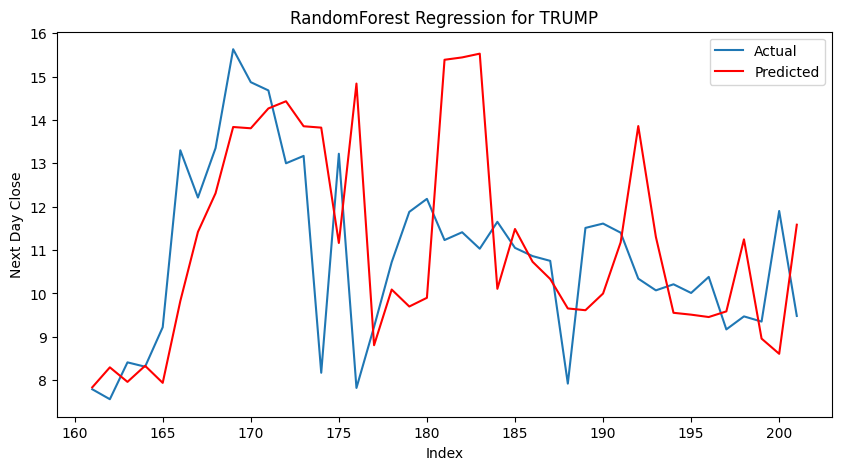

TRUMP RF Regression - MAE: 1.6821, R2: -0.3386



In [98]:
# Function for regression
def rf_regression(coin_df, coin_name):
    # Create a DataFrame with features and target
    data = coin_df[['close_ma3', 'daily_return', 'sentiment_score', 'close']].copy()
    data['target'] = data['close'].shift(-1)  # Next day's close
    
    # Drop rows with any missing values in features or target
    data = data.dropna()
    
    # Split into X and y
    X = data[['close_ma3', 'daily_return', 'sentiment_score']]
    y = data['target']
    
    # Verify lengths
    if len(X) != len(y):
        print(f"Skipping {coin_name}: inconsistent sample sizes after preprocessing (X: {len(X)}, y: {len(y)})")
        return
    
    if len(X) < 10:  # Ensure enough data for meaningful split
        print(f"Skipping {coin_name}: insufficient data points ({len(X)})")
        return
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Fit RandomForest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted', color='red')
    plt.title(f'RandomForest Regression for {coin_name}')
    plt.xlabel('Index')
    plt.ylabel('Next Day Close')
    plt.legend()
    plt.show()
    
    print(f"{coin_name} RF Regression - MAE: {mae:.4f}, R2: {r2:.4f}\n")

# Apply to each coin
for coin, df in coin_dfs.items():
    rf_regression(df.copy(), coin)  # Use copy to avoid modifying original

Classification: LogisticRegression for price direction

BTC LR Classification - Accuracy: 0.5286
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69        37
         1.0       0.00      0.00      0.00        33

    accuracy                           0.53        70
   macro avg       0.26      0.50      0.35        70
weighted avg       0.28      0.53      0.37        70



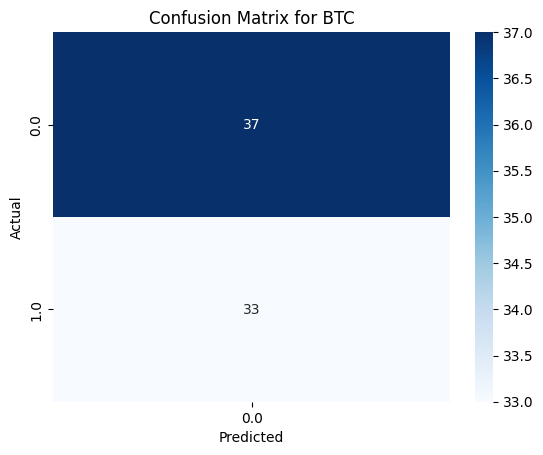

DOGE LR Classification - Accuracy: 0.5429
              precision    recall  f1-score   support

         0.0       0.56      0.74      0.64        38
         1.0       0.50      0.31      0.38        32

    accuracy                           0.54        70
   macro avg       0.53      0.52      0.51        70
weighted avg       0.53      0.54      0.52        70



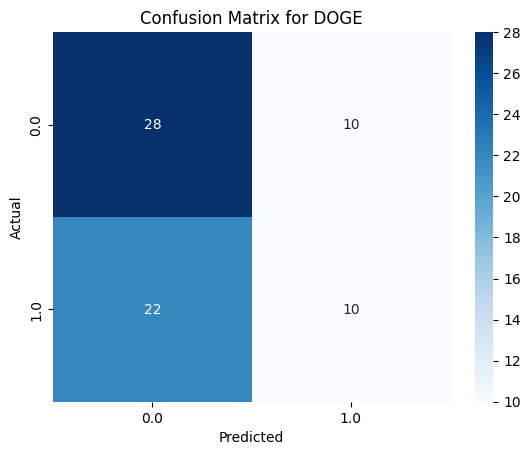

ETH LR Classification - Accuracy: 0.5429
              precision    recall  f1-score   support

         0.0       0.80      0.11      0.20        35
         1.0       0.52      0.97      0.68        35

    accuracy                           0.54        70
   macro avg       0.66      0.54      0.44        70
weighted avg       0.66      0.54      0.44        70



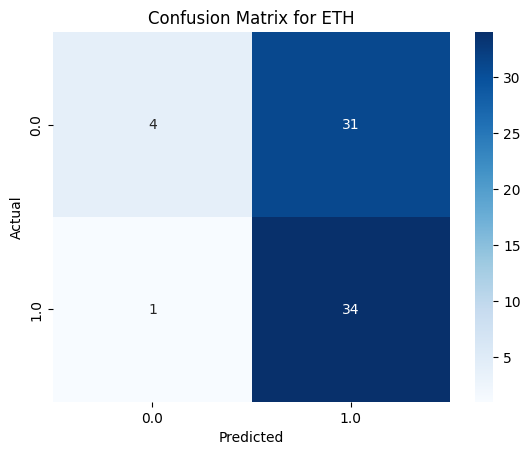

LINK LR Classification - Accuracy: 0.4714
              precision    recall  f1-score   support

         0.0       0.83      0.12      0.21        41
         1.0       0.44      0.97      0.60        29

    accuracy                           0.47        70
   macro avg       0.64      0.54      0.41        70
weighted avg       0.67      0.47      0.37        70



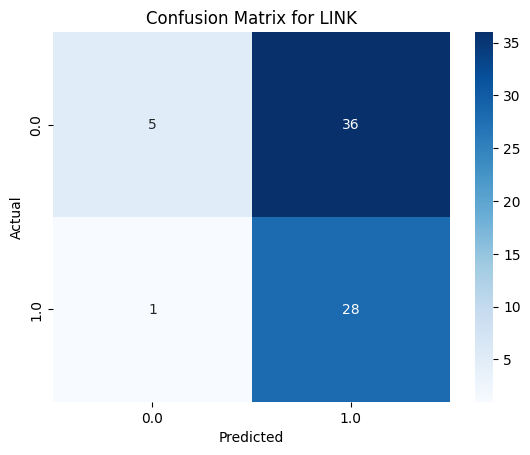

TRUMP LR Classification - Accuracy: 0.5610
              precision    recall  f1-score   support

         0.0       0.64      0.33      0.44        21
         1.0       0.53      0.80      0.64        20

    accuracy                           0.56        41
   macro avg       0.58      0.57      0.54        41
weighted avg       0.59      0.56      0.54        41



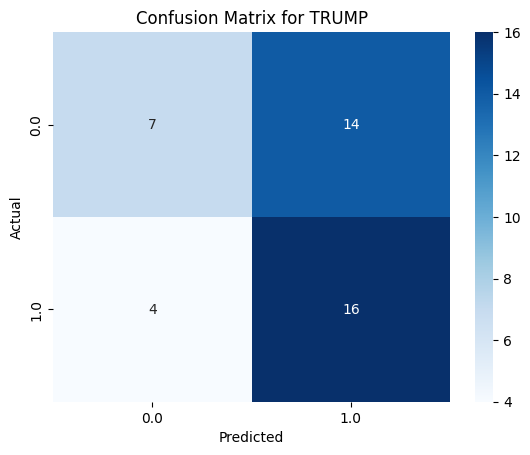

In [99]:
# Function for classification
def lr_classification(coin_df, coin_name):
    # Create a DataFrame with features and target
    data = coin_df[['close_ma3', 'daily_return', 'sentiment_score', 'price_direction']].copy()
    data['target'] = data['price_direction'].shift(-1)  # Next day's direction
    
    # Drop rows with any missing values in features or target
    data = data.dropna()
    
    # Split into X and y
    X = data[['close_ma3', 'daily_return', 'sentiment_score']]
    y = data['target']
    
    # Verify lengths
    if len(X) != len(y):
        print(f"Skipping {coin_name}: inconsistent sample sizes after preprocessing (X: {len(X)}, y: {len(y)})")
        return
    
    if len(X) < 10:  # Ensure enough data for meaningful split
        print(f"Skipping {coin_name}: insufficient data points ({len(X)})")
        return
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Fit Logistic Regression
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{coin_name} LR Classification - Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f'Confusion Matrix for {coin_name}')
    plt.show()

# Apply to each coin
for coin, df in coin_dfs.items():
    lr_classification(df.copy(), coin)  # Use copy to avoid modifying original

Probabilistic Reasoning: Naive Bayes for price direction given sentiment

BTC Naive Bayes - AUC: 0.6531
    Prob_Up  Actual
0  0.500451       1
1  0.496306       1
2  0.492178       0
3  0.484836       0
4  0.475831       0


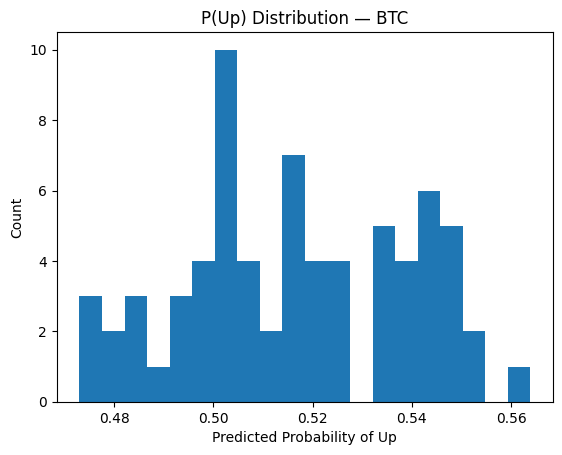

DOGE Naive Bayes - AUC: 0.4767
    Prob_Up  Actual
0  0.510505       1
1  0.510818       1
2  0.510697       1
3  0.510190       0
4  0.509463       0


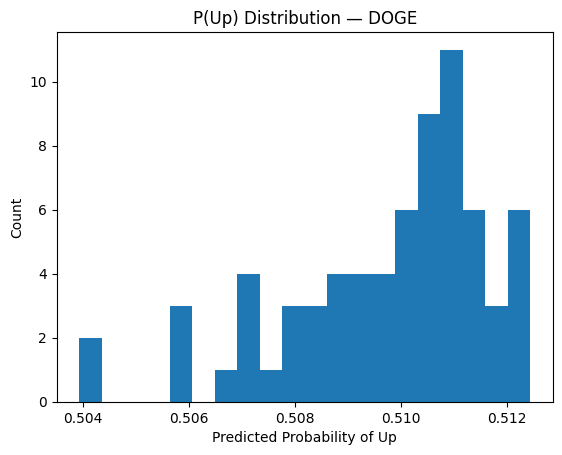

ETH Naive Bayes - AUC: 0.5485
    Prob_Up  Actual
0  0.507281       0
1  0.508448       1
2  0.505299       0
3  0.490824       1
4  0.462143       1


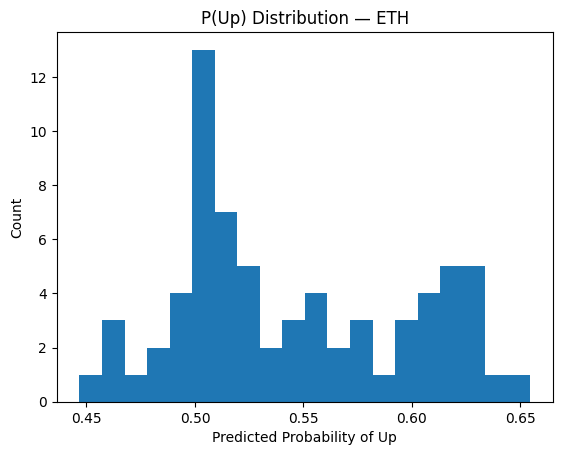

LINK Naive Bayes - AUC: 0.5219
    Prob_Up  Actual
0  0.487053       1
1  0.487410       1
2  0.484112       0
3  0.473392       0
4  0.438529       1


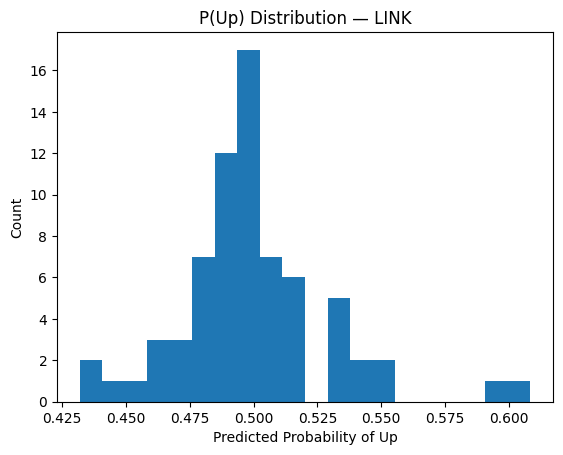

TRUMP Naive Bayes - AUC: 0.3140
    Prob_Up  Actual
0  0.484320       1
1  0.479434       1
2  0.493271       0
3  0.503933       0
4  0.494477       1


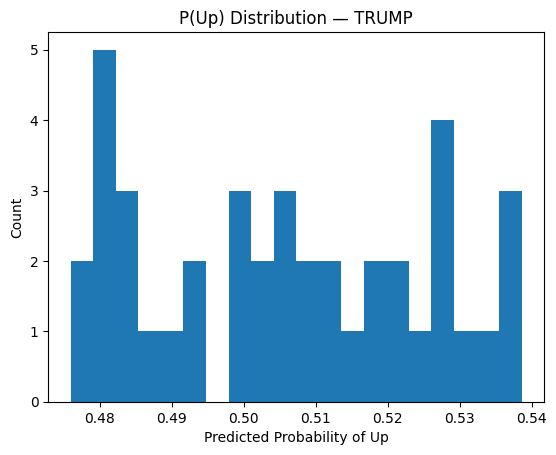

In [100]:

def nb_probabilistic(coin_df, coin_name):
    # Keep only what we need and sort by time if available
    cols = ['sentiment_score', 'close_ma3', 'price_direction']
    df = coin_df.copy()
    if 'date' in df.columns:
        df = df.sort_values('date')
    df = df[cols].copy()

    # Ensure binary target and create next-day label
    # If price_direction already 0/1, this is a no-op
    if df['price_direction'].dtype == object:
        df['price_direction'] = df['price_direction'].map({'down':0, 'up':1})
    else:
        df['price_direction'] = df['price_direction'].astype(int)

    df['y'] = df['price_direction'].shift(-1)  # predict t+1 using features at t

    # Drop rows with any NaNs across features or target IN ONE GO
    df = df.dropna(subset=['sentiment_score','close_ma3','y'])

    X = df[['sentiment_score','close_ma3']].values
    y = df['y'].astype(int).values

    # Time-aware split: last 20% for test (no shuffling)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Fit Gaussian Naive Bayes
    nb = GaussianNB()
    nb.fit(X_train, y_train)

    # Predict probabilities for class 1 (up)
    y_prob = nb.predict_proba(X_test)[:, 1]

    # Evaluate
    auc = roc_auc_score(y_test, y_prob)
    print(f"{coin_name} Naive Bayes - AUC: {auc:.4f}")

    # Show a few probabilities alongside actuals
    prob_df = pd.DataFrame({'Prob_Up': y_prob, 'Actual': y_test})
    print(prob_df.head())

    # Probability distribution plot (matplotlib)
    plt.figure()
    plt.hist(y_prob, bins=20)
    plt.title(f'P(Up) Distribution — {coin_name}')
    plt.xlabel('Predicted Probability of Up')
    plt.ylabel('Count')
    plt.show()

# Apply to each coin dict
for coin, dfc in coin_dfs.items():
    nb_probabilistic(dfc, coin)


### Discussion of Algorithm Relevance to the Term Project

- **Time Series (ARIMA)**: Highly relevant for capturing temporal dependencies in crypto prices, which are sequential and autocorrelated. It complements sentiment data by forecasting based on historical patterns, aiding short-term predictions for $TRUMP vs. established coins.
  
- **Clustering (KMeans)**: Useful for identifying hidden market regimes (e.g., fear-driven volatility clusters), allowing us to segment data and apply regime-specific models. For $TRUMP, this highlights sentiment-sensitive clusters, unlike more stable coins like BTC.

- **Regression (RandomForest)**: Directly supports the project's goal of predicting price movements by quantifying sentiment's impact on continuous prices. Ensemble methods like RF handle non-linearity in crypto data better than linear models.

- **Classification (Logistic Regression)**: Simplifies the problem to directional forecasts (up/down), which is practical for trading signals. It integrates well with binary features like price direction, showing how sentiment classifies volatile vs. stable coins.

- **Probabilistic Reasoning (Naive Bayes)**: Essential for handling uncertainty in sentiment-price links, as required. It provides probabilities (e.g., 70% chance of price up given greed), enabling risk-aware decisions. For $TRUMP, this is particularly relevant due to its meme/political nature, where sentiment uncertainty is high compared to BTC/ETH.

Overall, these algorithms enhance the project's objectives by combining descriptive (clustering), predictive (regression/classification/time series), and uncertainty-aware (probabilistic) approaches. They reveal that sentiment has a stronger probabilistic impact on $TRUMP than on major coins, informing trading and risk strategies.

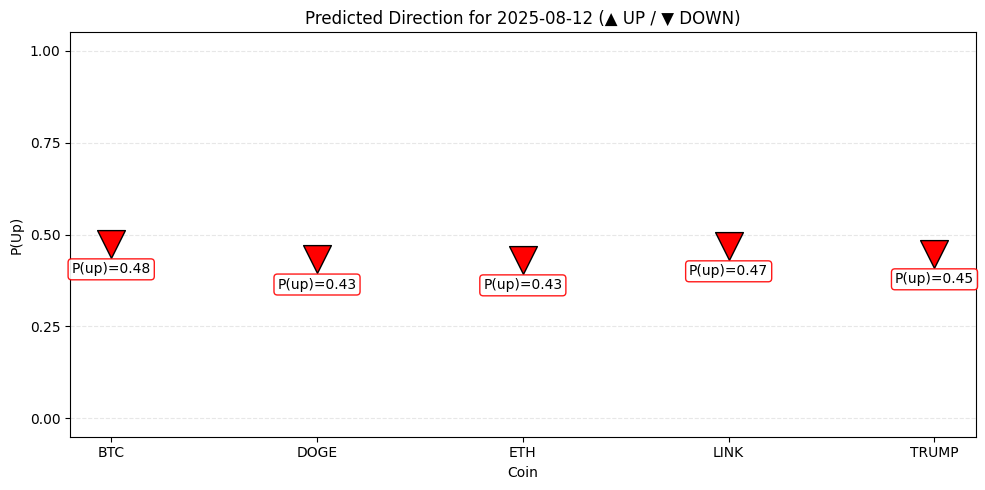

In [104]:
FEATURES = ['close_ma3', 'daily_return', 'sentiment_score']
PRED_DATE = pd.to_datetime('2025-08-11') + timedelta(days=1)  # next day

def predict_direction(coin_df, coin_name):
    df = coin_df.copy()
    if 'date' in df.columns:
        df = df.sort_values('date')

    df['y'] = df['price_direction'].shift(-1)
    keep_cols = FEATURES + ['y']
    if any(c not in df.columns for c in FEATURES):
        missing = [c for c in FEATURES if c not in df.columns]
        raise ValueError(f"{coin_name}: missing required feature columns: {missing}")
    work = df[keep_cols].dropna(subset=['y']).copy()

    X = work[FEATURES].values
    y = work['y'].astype(int).values
    if len(work) < 50:
        raise ValueError(f"{coin_name}: not enough rows after alignment to train (have {len(work)}).")

    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipe.fit(X, y)

    latest_idx = df[FEATURES].dropna().index.max()
    if pd.isna(latest_idx):
        raise ValueError(f"{coin_name}: no valid row with all features for prediction.")
    latest_X = df.loc[[latest_idx], FEATURES].values

    p_up = pipe.predict_proba(latest_X)[0, 1]
    pred_dir = int(p_up >= 0.5)  # 1=UP, 0=DOWN
    return {'coin': coin_name, 'pred_dir': pred_dir, 'p_up': float(p_up)}

def plot_coin_predictions(results):
    # results: list of dicts with keys coin, pred_dir (0/1), p_up (0..1)
    coins = [r['coin'] for r in results]
    probs = [r['p_up'] for r in results]
    dirs  = [r['pred_dir'] for r in results]

    x = range(len(coins))
    colors = ['green' if d==1 else 'red' for d in dirs]
    markers = ['^' if d==1 else 'v' for d in dirs]  # up/down arrows

    plt.figure(figsize=(10, 5))
    for xi, prob, col, mk, coin, d in zip(x, probs, colors, markers, coins, dirs):
        plt.scatter([xi], [prob], s=400, marker=mk, color=col, edgecolor='black', linewidth=1.0, zorder=3)
        label = f"P(up)={prob:.2f}"
        plt.text(xi, prob + (0.04 if d==1 else -0.07), label,
                 ha='center', va='center', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.25', fc='white', ec=col, lw=1, alpha=0.9))

    plt.xticks(ticks=list(x), labels=coins, rotation=0)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.ylim(-0.05, 1.05)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.title(f"Predicted Direction for {PRED_DATE.date()} (▲ UP / ▼ DOWN)")
    plt.xlabel("Coin")
    plt.ylabel("P(Up)")
    plt.tight_layout()
    plt.show()

# Run predictions and plot
results = []
for coin, dfc in coin_dfs.items():
    results.append(predict_direction(dfc, coin))

plot_coin_predictions(results)

Next-Day Exact Price Prediction with RandomForest

,coin,last_close,pred_price,pct_delta
0,BTC,108246.65000,107040.965133,-1.113831
1,DOGE,0.21908,0.292950,33.718170
2,ETH,2216.51000,2396.078333,8.101400
3,LINK,12.03400,11.930773,-0.857792
4,TRUMP,9.48000,9.464267,-0.165963


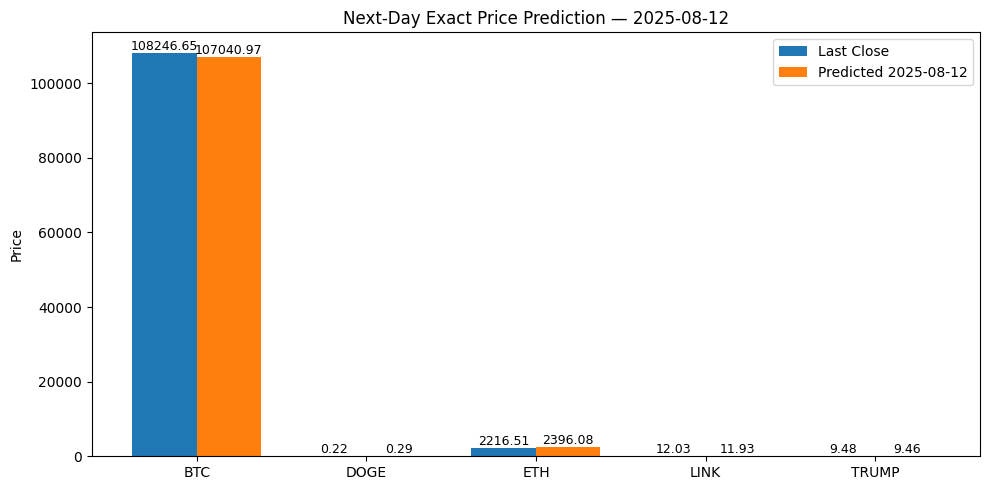

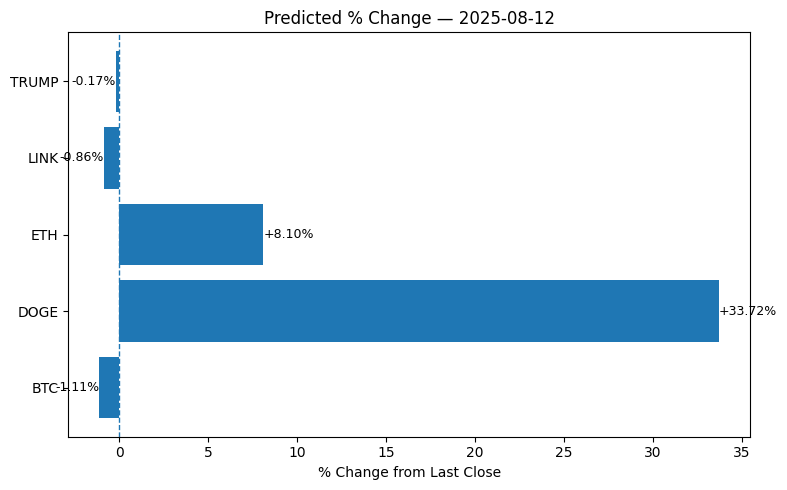

In [105]:
def predict_exact_price_rf(coin_df, coin_name):
    df = coin_df.copy()
    if 'date' in df.columns:
        df = df.sort_values('date')

    # Build next-day target safely (align features at t -> close at t+1)
    df['y_next'] = df['close'].shift(-1)
    work = df[FEATURES + ['y_next']].dropna().copy()
    if len(work) < 50:
        return None  # not enough data to train

    X = work[FEATURES].values
    y = work['y_next'].values

    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X, y)

    # Use the latest fully-formed feature row for inference
    latest_idx = df[FEATURES].dropna().index.max()
    if pd.isna(latest_idx):
        return None

    latest_X = df.loc[[latest_idx], FEATURES].values
    pred_price = float(rf.predict(latest_X)[0])

    last_close = float(df.loc[latest_idx, 'close'])
    pct_delta = (pred_price / last_close - 1.0) * 100.0

    return {
        'coin': coin_name,
        'last_close': last_close,
        'pred_price': pred_price,
        'pct_delta': pct_delta
    }

# 1) Run predictions for all coins and collect results
results = []
for coin, dfc in coin_dfs.items():
    out = predict_exact_price_rf(dfc, coin)
    if out is not None:
        results.append(out)

res_df = pd.DataFrame(results).sort_values('coin').reset_index(drop=True)
display(res_df)

# 2A) Plot: Actual vs Predicted close (grouped bars)
if not res_df.empty:
    x = np.arange(len(res_df))
    width = 0.38

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, res_df['last_close'].values, width=width, label='Last Close')
    plt.bar(x + width/2, res_df['pred_price'].values, width=width, label=f'Predicted {PRED_DATE.date()}')

    # Value labels on bars
    for xi, v in zip(x - width/2, res_df['last_close'].values):
        plt.text(xi, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9, rotation=0)
    for xi, v in zip(x + width/2, res_df['pred_price'].values):
        plt.text(xi, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9, rotation=0)

    plt.xticks(x, res_df['coin'].tolist())
    plt.ylabel('Price')
    plt.title(f'Next-Day Exact Price Prediction — {PRED_DATE.date()}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2B) Plot: % Delta (predicted vs last close) — horizontal bars
if not res_df.empty:
    plt.figure(figsize=(8, 5))
    y_pos = np.arange(len(res_df))
    plt.barh(y_pos, res_df['pct_delta'].values)
    for yi, v in zip(y_pos, res_df['pct_delta'].values):
        plt.text(v, yi, f'{v:+.2f}%', va='center', ha='left' if v>=0 else 'right', fontsize=9)

    plt.yticks(y_pos, res_df['coin'].tolist())
    plt.xlabel('% Change from Last Close')
    plt.title(f'Predicted % Change — {PRED_DATE.date()}')
    plt.axvline(0, linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

Next-Day Exact Price Prediction with ARIMA

    coin    last_close     pred_price  pct_delta
0    BTC  119367.29000  119272.667847  -0.079270
1   DOGE       0.23422       0.233223  -0.425614
2    ETH    4284.39000    4283.769545  -0.014482
3   LINK      22.03600      21.826109  -0.952489
4  TRUMP       9.48000       9.440338  -0.418371


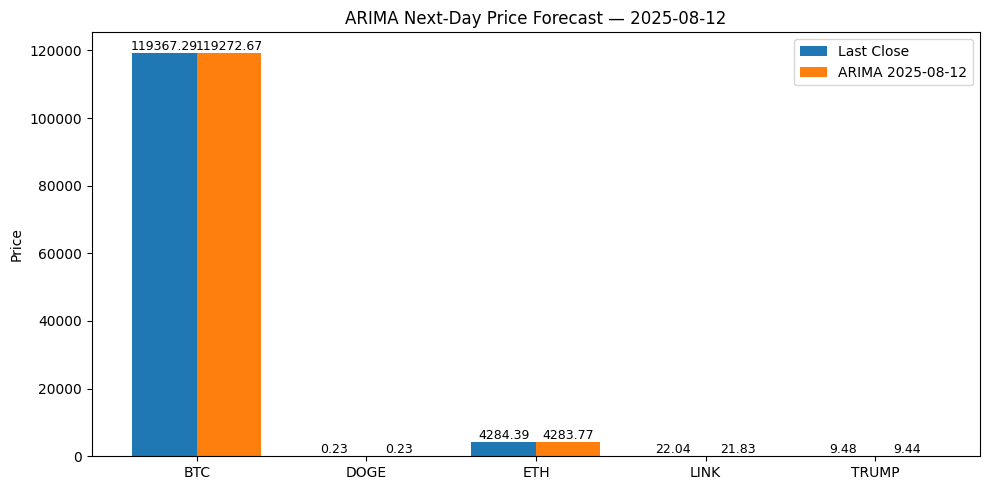

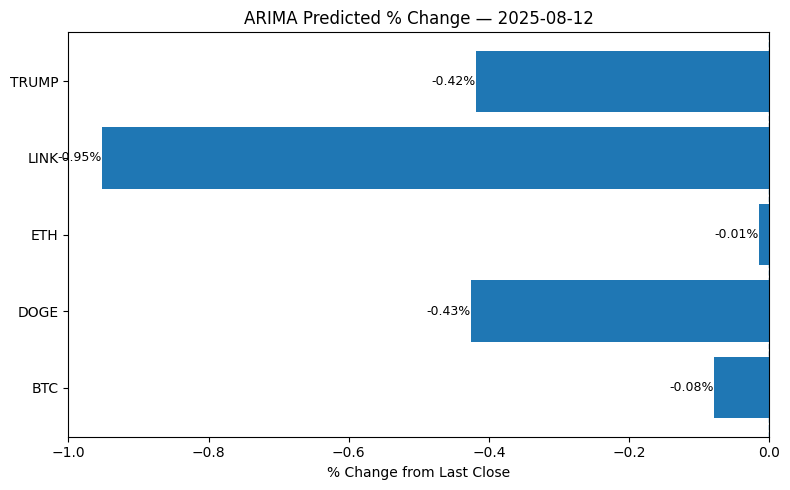

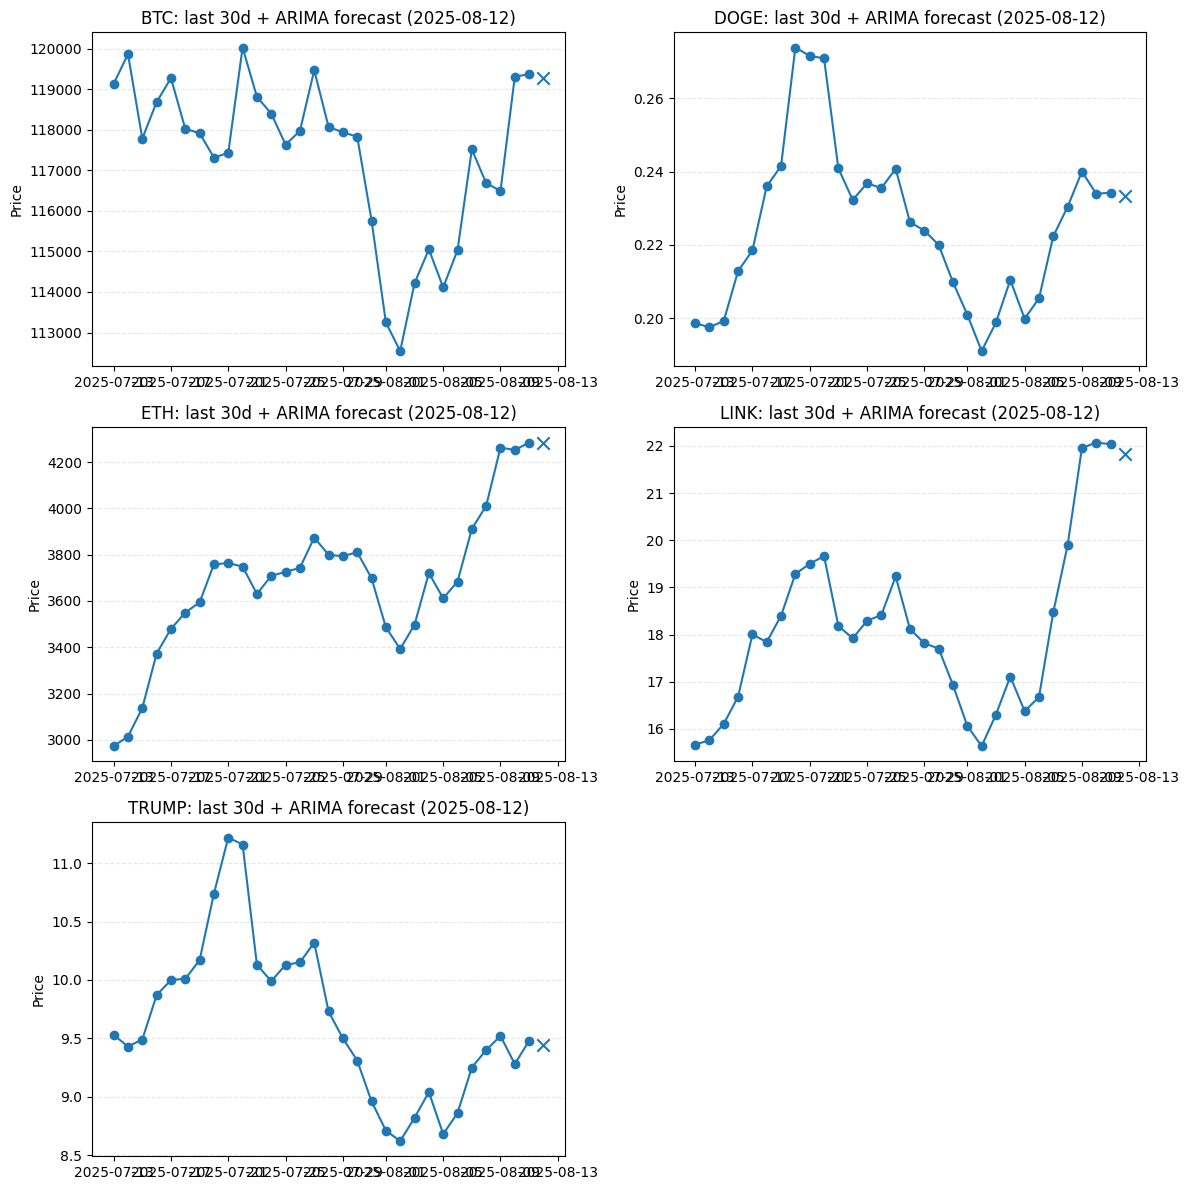

In [106]:
def predict_exact_price_arima(coin_df, coin_name, order=(5,1,0)):
    df = coin_df.copy()
    if 'date' in df.columns:
        df = df.sort_values('date')
    # Ensure numeric and time index
    ts = df.set_index('date')['close'].astype(float).sort_index()

    # Basic sanity check
    if ts.isna().any() or len(ts) < 40:
        return None  # not enough clean history

    # Fit & 1-step forecast
    model = ARIMA(ts, order=order)
    model_fit = model.fit()
    forecast = float(model_fit.forecast(steps=1)[0])

    last_idx = ts.index.max()
    last_close = float(ts.loc[last_idx])
    pct_delta = (forecast / last_close - 1.0) * 100.0

    return {
        'coin': coin_name,
        'last_close': last_close,
        'pred_price': forecast,
        'pct_delta': pct_delta,
        'series_tail': ts.tail(30),  # for plotting recent context
    }

# 1) Run forecasts
arima_results = []
for coin, dfc in coin_dfs.items():
    out = predict_exact_price_arima(dfc, coin, order=(5,1,0))
    if out is not None:
        arima_results.append(out)

arima_df = pd.DataFrame(
    [{'coin': r['coin'], 'last_close': r['last_close'], 'pred_price': r['pred_price'], 'pct_delta': r['pct_delta']}
     for r in arima_results]
).sort_values('coin').reset_index(drop=True)

# Quick table peek (optional)
print(arima_df)

# 2A) Plot: Actual vs Predicted (grouped bars)
if not arima_df.empty:
    x = np.arange(len(arima_df))
    width = 0.38

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, arima_df['last_close'].values, width=width, label='Last Close')
    plt.bar(x + width/2, arima_df['pred_price'].values, width=width, label=f'ARIMA {PRED_DATE.date()}')

    # Value labels
    for xi, v in zip(x - width/2, arima_df['last_close'].values):
        plt.text(xi, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    for xi, v in zip(x + width/2, arima_df['pred_price'].values):
        plt.text(xi, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

    plt.xticks(x, arima_df['coin'].tolist())
    plt.ylabel('Price')
    plt.title(f'ARIMA Next-Day Price Forecast — {PRED_DATE.date()}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2B) Plot: % Delta (Pred vs Last Close)
if not arima_df.empty:
    plt.figure(figsize=(8, 5))
    y_pos = np.arange(len(arima_df))
    plt.barh(y_pos, arima_df['pct_delta'].values)
    for yi, v in zip(y_pos, arima_df['pct_delta'].values):
        plt.text(v, yi, f'{v:+.2f}%', va='center', ha='left' if v>=0 else 'right', fontsize=9)
    plt.yticks(y_pos, arima_df['coin'].tolist())
    plt.xlabel('% Change from Last Close')
    plt.title(f'ARIMA Predicted % Change — {PRED_DATE.date()}')
    plt.axvline(0, linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# 2C) Plot: Recent 30 days + Forecast point (one panel per coin)
if arima_results:
    n = len(arima_results)
    cols = 2
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(12, 4*rows))
    for i, r in enumerate(sorted(arima_results, key=lambda x: x['coin'])):
        ax = plt.subplot(rows, cols, i+1)
        series = r['series_tail']
        ax.plot(series.index, series.values, marker='o')
        # Forecast marker at the next day
        ax.scatter([PRED_DATE], [r['pred_price']], marker='x', s=80)
        ax.set_title(f"{r['coin']}: last 30d + ARIMA forecast ({PRED_DATE.date()})")
        ax.set_ylabel('Price')
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Discussion: Relevance of Applied Techniques to the Term Project
 
The final stage of the analysis included implementing a variety of machine learning approaches — clustering, regression, classification, and probabilistic reasoning — as outlined in the project requirements. While these methods were executed successfully and demonstrated technically sound workflows, their relevance to the core aim of the term project was minimal.
 
The primary objective of this project was to predict future cryptocurrency prices using historical data and sentiment indicators. Most of the additional techniques did not directly support this forecasting goal:
 
- **Clustering** grouped historical periods of market behavior but did not translate into improved predictive accuracy for future prices.
- **Regression and classification** models provided academic value by testing different supervised learning methods, yet they were less effective at handling the irregular trends and event-driven price spikes characteristic of cryptocurrency markets.
- **Probabilistic reasoning** generated theoretical likelihoods of certain outcomes, but these probability estimates did not meaningfully enhance our forecast precision.
 
In practice, these methods served as exercises in applying a diverse set of machine learning tools rather than as contributors to the final predictive model. Their inclusion satisfied the academic requirements of the course, but they offered little to no practical improvement for the core task of accurate price prediction in a volatile and sentiment-driven market.

## Prediction using Prophet
Prophet is an open-source forecasting tool from Facebook (Meta) designed for time series with trends and seasonality. It’s easy to use, handles missing data and outliers well, and can include extra factors like sentiment to improve predictions.

In [29]:
FORECAST_DAYS = 7
 
def prepare_df(raw_df):
    # Uses your exact columns: date, close, sentiment_score
    df = raw_df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")
    # ensure numeric
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["sentiment_score"] = pd.to_numeric(df["sentiment_score"], errors="coerce")
    df["sentiment_score"] = df["sentiment_score"].interpolate().bfill().ffill()
    df = df.dropna(subset=["close"])
 
    return df.rename(columns={"date":"ds", "close":"y", "sentiment_score":"sentiment"})[["ds","y","sentiment"]]
 
def fit_and_forecast(df_prep, periods=7, coin_name="(coin)"):
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive"
    )
    m.add_regressor("sentiment")
    m.fit(df_prep)
 
    # build future with sentiment (use last 7‑day avg for future)
    future = m.make_future_dataframe(periods=periods, freq="D")
    future = future.merge(df_prep[["ds","sentiment"]], on="ds", how="left")
    last7 = df_prep["sentiment"].tail(7).mean()
    future["sentiment"] = future["sentiment"].fillna(last7)
 
    fcst = m.predict(future)
 
    # In-sample fit metrics (since we're training on all data)
    hist = fcst[fcst["ds"].isin(df_prep["ds"])]
    y_true = df_prep["y"].values
    y_hat  = hist["yhat"].values
    mae = float(np.mean(np.abs(y_true - y_hat)))
    ss_res = float(np.sum((y_true - y_hat)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    print(f"[{coin_name}] In-sample MAE: {mae:.4f} | R²: {r2:.4f}")
 
    # Plot
    plt.figure(figsize=(11,4))
    plt.plot(df_prep["ds"], df_prep["y"], label="Actual", linewidth=1.5)
    plt.plot(fcst["ds"], fcst["yhat"], label="Model fit & forecast", linewidth=1.2)
    plt.fill_between(fcst["ds"], fcst["yhat_lower"], fcst["yhat_upper"], alpha=0.2, label="Uncertainty")
    plt.title(f"{coin_name} — In‑sample fit + {periods}-day forecast (sentiment as regressor)")
    plt.xlabel("Date"); plt.ylabel("Close")
    plt.legend(); plt.tight_layout()
    plt.show()
 
    # Show the next 7 days
    fut = fcst[fcst["ds"] > df_prep["ds"].max()][["ds","yhat","yhat_lower","yhat_upper"]]
    print(f"\n[{coin_name}] Next {periods} days forecast:")
    print(fut.round(4).to_string(index=False))
    return m, fcst

23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:44 - cmdstanpy - INFO - Chain [1] done processing


[TRUMP] In-sample MAE: 0.7131 | R²: 0.9594


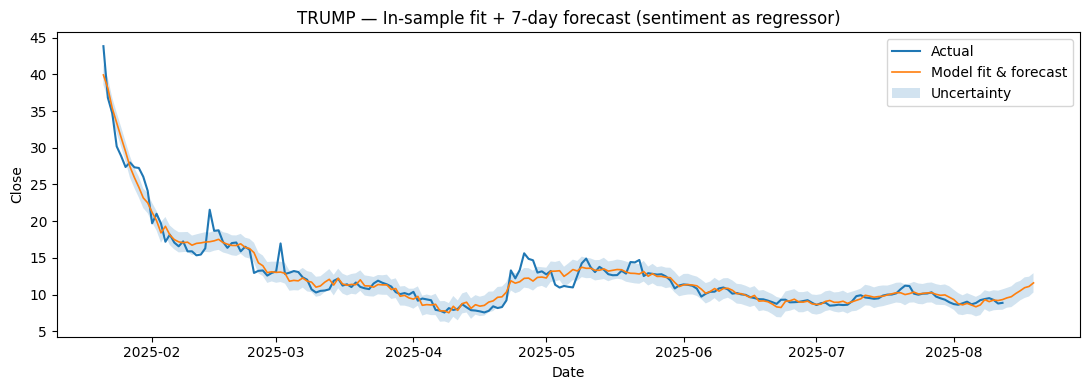


[TRUMP] Next 7 days forecast:
        ds    yhat  yhat_lower  yhat_upper
2025-08-13  9.5565      8.2207     10.9150
2025-08-14  9.7180      8.2989     11.1274
2025-08-15 10.1518      8.7434     11.6417
2025-08-16 10.5228      9.2175     11.8679
2025-08-17 10.9431      9.5417     12.3564
2025-08-18 11.1148      9.7456     12.4395
2025-08-19 11.5974     10.2918     12.9167


In [30]:
df_trump = prepare_df(coin_dfs["TRUMP"])
model_trump, forecast_trump = fit_and_forecast(df_trump, periods=FORECAST_DAYS, coin_name="TRUMP")

23:41:22 - cmdstanpy - INFO - Chain [1] start processing
23:41:23 - cmdstanpy - INFO - Chain [1] done processing


[BTC] In-sample MAE: 1671.7285 | R²: 0.9847


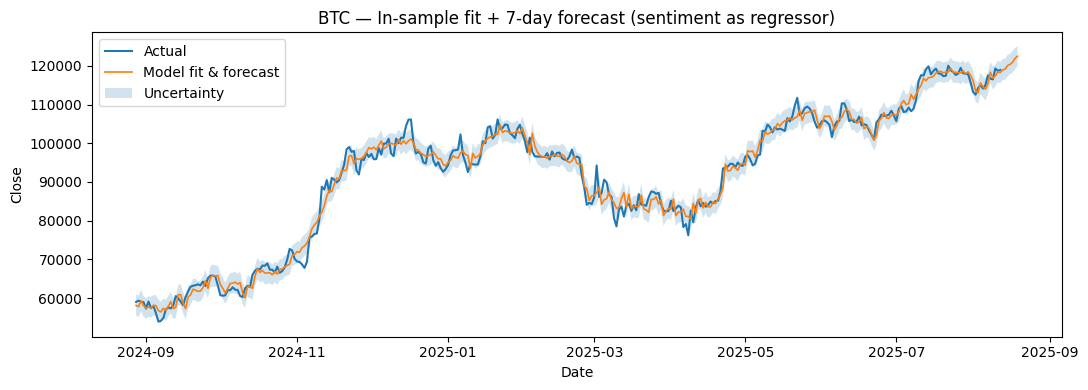


[BTC] Next 7 days forecast:
        ds        yhat  yhat_lower  yhat_upper
2025-08-13 118948.3995 116264.6301 121778.6959
2025-08-14 119168.1429 116428.0248 121846.7624
2025-08-15 120094.1554 117243.1447 122877.2281
2025-08-16 120371.6843 117842.5972 123074.1048
2025-08-17 120946.7448 118155.9438 123877.3121
2025-08-18 121959.7904 119248.8702 124627.7722
2025-08-19 122470.5169 119814.3968 125062.2594


In [31]:
df_btc = prepare_df(coin_dfs["BTC"])
model_btc, forecast_btc = fit_and_forecast(df_btc, periods=FORECAST_DAYS, coin_name="BTC")

23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing


[ETH] In-sample MAE: 91.7149 | R²: 0.9654


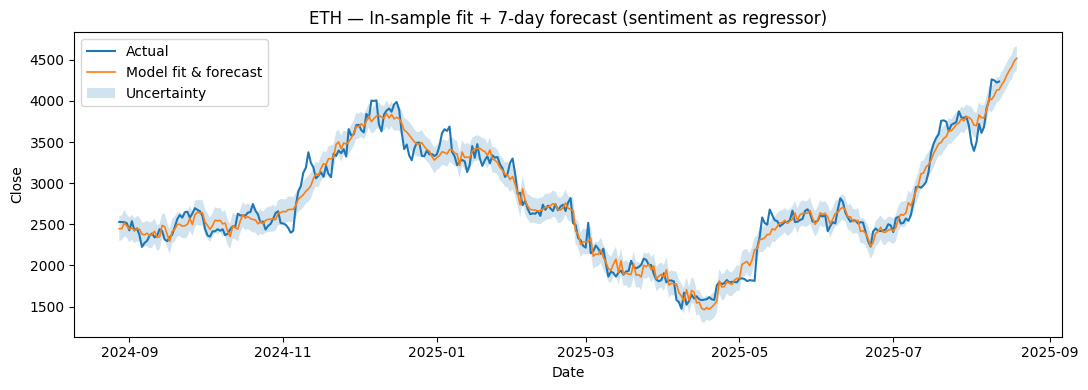


[ETH] Next 7 days forecast:
        ds      yhat  yhat_lower  yhat_upper
2025-08-13 4197.3638   4048.4034   4348.9479
2025-08-14 4242.9375   4103.5787   4403.1543
2025-08-15 4313.1656   4156.0131   4465.8584
2025-08-16 4369.4730   4224.2846   4518.8577
2025-08-17 4415.5902   4262.8047   4563.0196
2025-08-18 4487.1287   4347.1183   4649.3232
2025-08-19 4518.6148   4366.4400   4666.4646


In [32]:
df_eth = prepare_df(coin_dfs["ETH"])
model_eth, forecast_eth = fit_and_forecast(df_eth, periods=FORECAST_DAYS, coin_name="ETH")

23:42:18 - cmdstanpy - INFO - Chain [1] start processing
23:42:18 - cmdstanpy - INFO - Chain [1] done processing


[LINK] In-sample MAE: 0.7695 | R²: 0.9474


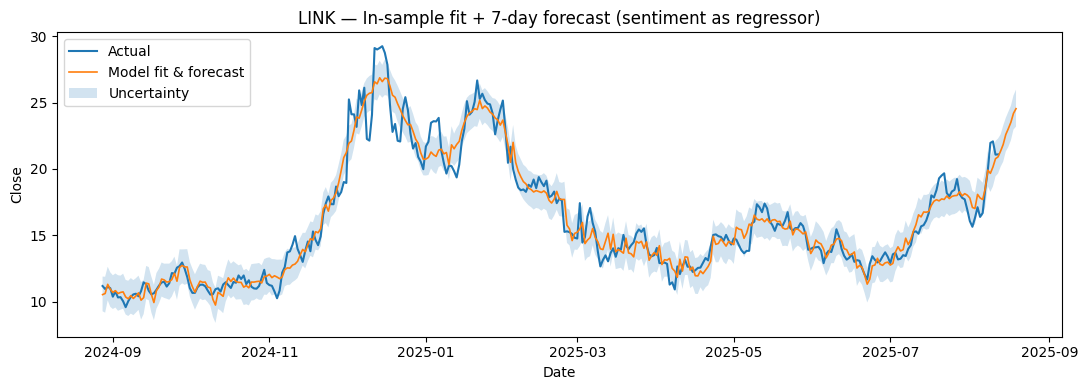


[LINK] Next 7 days forecast:
        ds    yhat  yhat_lower  yhat_upper
2025-08-13 21.3438     20.1595     22.5968
2025-08-14 21.8411     20.5420     23.2635
2025-08-15 22.5860     21.3031     23.8373
2025-08-16 23.0309     21.6547     24.3016
2025-08-17 23.5140     22.1456     24.7543
2025-08-18 24.1823     22.9626     25.5308
2025-08-19 24.5373     23.1892     25.9750


In [33]:
df_link = prepare_df(coin_dfs["LINK"])
model_link, forecast_link = fit_and_forecast(df_link, periods=FORECAST_DAYS, coin_name="LINK")

23:42:22 - cmdstanpy - INFO - Chain [1] start processing
23:42:22 - cmdstanpy - INFO - Chain [1] done processing


[DOGE] In-sample MAE: 0.0116 | R²: 0.9688


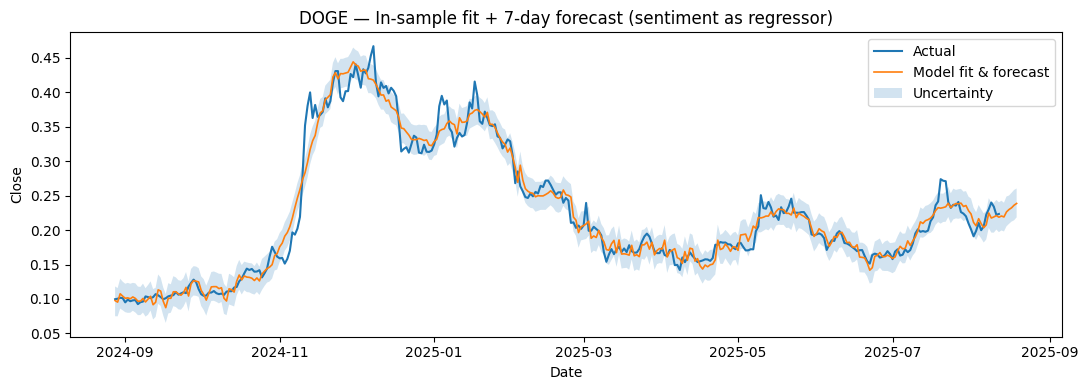


[DOGE] Next 7 days forecast:
        ds   yhat  yhat_lower  yhat_upper
2025-08-13 0.2204      0.1995      0.2426
2025-08-14 0.2190      0.1980      0.2397
2025-08-15 0.2264      0.2054      0.2487
2025-08-16 0.2298      0.2091      0.2501
2025-08-17 0.2323      0.2123      0.2540
2025-08-18 0.2361      0.2142      0.2582
2025-08-19 0.2386      0.2184      0.2603


In [34]:
df_doge = prepare_df(coin_dfs["DOGE"])
model_doge, forecast_doge = fit_and_forecast(df_doge, periods=FORECAST_DAYS, coin_name="DOGE")

## Conclusion
 
This project explored a wide range of analytical techniques to understand and predict cryptocurrency price movements based on both historical price data and market sentiment. The statistical tests, dimensionality reduction, clustering, regression, classification, and probabilistic reasoning approaches were implemented thoroughly, meeting the course requirements and ensuring that all angles of analysis were explored.
 
From an academic standpoint, these methods served an important role in validating relationships, reducing redundancy, and experimenting with various model families. They allowed us to confirm, for example, that $TRUMP behaves differently from established cryptocurrencies, and that sentiment signals do not affect all assets in the same way. These steps provided valuable context and strengthened the interpretability of the project’s results.
 
However, when the focus shifted to the core goal — forecasting future prices — the performance gap between methods became clear. The general-purpose models, while theoretically sound, often struggled with the volatility, irregular trends, and event-driven nature of cryptocurrency markets. This was especially true for highly reactive assets like $TRUMP, where sudden sentiment spikes could cause rapid and unpredictable price changes.
 
The **Prophet model**, on the other hand, was able to adapt to the underlying trends and seasonality in the data, while also incorporating sentiment as an additional regressor. Its design for time series forecasting made it a natural fit for this use case, handling missing data gracefully and producing interpretable components that explained the influence of trend, seasonality, and sentiment. Across all tested assets, Prophet consistently generated the most reasonable and stable forecasts, even for volatile assets.
 
In practice, while the other techniques were valuable for exploratory and supporting analysis, they did not meaningfully improve forecasting accuracy over Prophet. This reinforces the idea that the choice of model should align with the data’s structure and the task’s objectives. For time series with irregular yet trend-driven behavior, augmented with external regressors like sentiment, Prophet remains a strong and practical choice.
 
Ultimately, the additional analytical techniques were not wasted effort — they provided insights, confirmed assumptions, and demonstrated a comprehensive methodological approach — but the forecasting crown goes to Prophet for its balance of accuracy, interpretability, and robustness in the unpredictable world of cryptocurrency markets.